# House price prediction 

This notebook shows the solution of a regression problem using the Ames Housing dataset as an example. 
Data taken from this <a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview">
Kaggle competition </a>.

The structure of this notebook is as follows:

- **[1. Data loading and preprocessing](#h1)**
    - [1.1 First look on data type and structure](#h1.1)
    - [1.2 Review of the missing data](#h1.2)
    - [1.3 Cleaning categorical features](#h1.3)
    - [1.4 Handling categorical variables ](#h1.4)
    - [1.5 Load and preprocessing data](#h1.5)
    - [1.6 House price distribution ](#h1.6)
- **[2. Ensemble model baseline](#h2)**
- **[3. Feature Utility Score (Mutual information)](#h3)**
    - [3.1 MI filtering in pipeline](#h3.1)
- **[4. Feature engineering](#h.4)**
    - [4.1 Math feature transformation](#h4.1)
        - [4.1.1 Data normalization](#h4.1.1)
        - [4.1.2 Accumulation of various transformation of numerical features](#h4.1.2)
        - [4.1.3 Removing correlating features](#h4.1.3)
    - [4.2 k-Means clustering](#h4.2)
        - [4.2.1 Cluster labels](#h4.2.1)
        - [4.2.1 Cluster distance](#h4.2.2)
    - [4.3 PCA](#h4.3)
- **[5. Outliers](#h5)**
    - [5.1 Cook's distance](#h5.1)
    - [5.2 DBSCAN](#h5.2)
    - [5.3 Summury](#h5.3)
- **[6. Targetn encoding](#h6)**
- **[7. Hyperparameter optimization](#h7)**
    - [7.1 XGBRegressor parameter optimization](#h7.1)
    - [7.2 LGBMRegressor parameter optimization](#h7.2)
    - [7.3 GradientBoostingRegressor parameter optimization](#h7.3)    

In [1]:
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression, SelectFromModel, SelectKBest
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.ensemble import GradientBoostingRegressor as skGBR, RandomForestRegressor as skRFR
from xgboost import XGBRegressor
import lightgbm as lgb

import statsmodels.api as sm

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

In [2]:
''' Plot settings'''

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

# 1. Data loading and preprocessing  <a class="anchor" id="h1"></a>

In [3]:
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')
df_all = pd.concat([df_train.drop('SalePrice',axis=1),df_test])

## 1.1 First look on data type and structure  <a class="anchor" id="h1.1"></a>

In [4]:
print(df_train.shape)
print(df_test.shape)

(1460, 80)
(1459, 79)


In [5]:
df_train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

The data  is composed of 79 features and 1460 entries

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Based on the data description, categorical features are selected, consisting of object columns and three columns of an integer type:

In [7]:
''' Columns of categorical features: columns with object type and 3 cols of int categories'''

cat_cols = [col for col in df_train.columns if df_train[col].dtype == 'object'] + ['MSSubClass', 'OverallQual','OverallCond']

In [8]:
df_train[cat_cols].head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
Id                                                                            
1        RL   Pave   NaN      Reg         Lvl    AllPub    Inside       Gtl   
2        RL   Pave   NaN      Reg         Lvl    AllPub       FR2       Gtl   
3        RL   Pave   NaN      IR1         Lvl    AllPub    Inside       Gtl   
4        RL   Pave   NaN      IR1         Lvl    AllPub    Corner       Gtl   
5        RL   Pave   NaN      IR1         Lvl    AllPub       FR2       Gtl   

   Neighborhood Condition1  ... GarageCond PavedDrive PoolQC Fence  \
Id                          ...                                      
1       CollgCr       Norm  ...         TA          Y    NaN   NaN   
2       Veenker      Feedr  ...         TA          Y    NaN   NaN   
3       CollgCr       Norm  ...         TA          Y    NaN   NaN   
4       Crawfor       Norm  ...         TA          Y    NaN   NaN   
5       NoRidge       Norm  ...         TA          Y    NaN   NaN   

   MiscFeature SaleType SaleCondition MSSubClass OverallQual OverallCond  
Id                                                                        
1          NaN       WD        Normal         60           7           5  
2          NaN       WD        Normal         20           6           8  
3          NaN       WD        Normal         60           7           5  
4          NaN       WD       Abnorml         70           7           5  
5          NaN       WD        Normal         60           8           5  

[5 rows x 46 columns]

## 1.2 Review of the missing data  <a class="anchor" id="h1.2"></a>

In [9]:
'''Missing data review function'''

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (round(total/data.shape[0]*100,2)).sort_values(ascending = False)
    df_missing = pd.concat([total, percent, data.dtypes, data.nunique(dropna=True)], axis=1, keys=['total', 'percent','dtype','nunique'])
    return df_missing[df_missing.total > 0]

As the test data is provided, it will be used along with the training data in the process of data cleaning and categorical feature encoding.

In [10]:
missing_data(df_all)

total  percent    dtype  nunique
PoolQC         2909    99.66   object        3
MiscFeature    2814    96.40   object        4
Alley          2721    93.22   object        2
Fence          2348    80.44   object        4
FireplaceQu    1420    48.65   object        5
LotFrontage     486    16.65  float64      128
GarageYrBlt     159     5.45  float64      103
GarageFinish    159     5.45   object        3
GarageQual      159     5.45   object        5
GarageCond      159     5.45   object        5
GarageType      157     5.38   object        6
BsmtExposure     82     2.81   object        4
BsmtCond         82     2.81   object        4
BsmtQual         81     2.77   object        4
BsmtFinType2     80     2.74   object        6
BsmtFinType1     79     2.71   object        6
MasVnrType       24     0.82   object        4
MasVnrArea       23     0.79  float64      444
MSZoning          4     0.14   object        5
Functional        2     0.07   object        7
BsmtHalfBath      2     0.07  float64        3
BsmtFullBath      2     0.07  float64        4
Utilities         2     0.07   object        2
SaleType          1     0.03   object        9
BsmtFinSF1        1     0.03  float64      991
KitchenQual       1     0.03   object        4
GarageCars        1     0.03  float64        6
BsmtUnfSF         1     0.03  float64     1135
TotalBsmtSF       1     0.03  float64     1058
Exterior2nd       1     0.03   object       16
Exterior1st       1     0.03   object       15
GarageArea        1     0.03  float64      603
Electrical        1     0.03   object        5
BsmtFinSF2        1     0.03  float64      272

## 1.3 Cleaning categorical features  <a class="anchor" id="h1.3"></a>

Cleaning and unifying the categories of the object features.

In [11]:
''' Let's look at the unique entries in the categorical data'''

for col in cat_cols:
    print(col, df_all[col].unique(), '\n')

MSZoning ['RL' 'RM' 'C (all)' 'FV' 'RH' nan] 

Street ['Pave' 'Grvl'] 

Alley [nan 'Grvl' 'Pave'] 

LotShape ['Reg' 'IR1' 'IR2' 'IR3'] 

LandContour ['Lvl' 'Bnk' 'Low' 'HLS'] 

Utilities ['AllPub' 'NoSeWa' nan] 

LotConfig ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] 

LandSlope ['Gtl' 'Mod' 'Sev'] 

Neighborhood ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'] 

Condition1 ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe'] 

Condition2 ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'] 

BldgType ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs'] 

HouseStyle ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] 

RoofStyle ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed'] 

RoofMatl ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTil

In [12]:
def clean(df):
    # Correcting some obvious typos
    df["Exterior2nd"] = df["Exterior2nd"].replace({"Brk Cmn": "BrkComm"})    
    # Some values of GarageYrBlt are corrupt (is Nan), so replacing them
    # with the year the house was built
    df["GarageYrBlt"] = df["GarageYrBlt"].where(df.GarageYrBlt <= 2010, df.YearBuilt)
    # Names beginning with numbers are awkward to work with
    df.rename(columns={
        "1stFlrSF": "FirstFlrSF",
        "2ndFlrSF": "SecondFlrSF",
        "3SsnPorch": "Threeseasonporch",
    }, inplace=True,
    )
    return df

------------------

## 1.4 Handling categorical variables  <a class="anchor" id="h1.4"></a>

In [13]:
''' There are many cat. features with 5 and 10 levels'''
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

In [14]:
five_cols = [col for col in cat_cols if len(set(df_all[col].unique()) - set(five_levels)) <=1]
print(five_cols)
ten_cols = [col for col in cat_cols if len(set(df_all[col].unique()) - set(ten_levels)) <=1]
print(ten_cols)

['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
['OverallQual', 'OverallCond']


In [15]:
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The nominative (unordered) categorical features
features_nom = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood","Condition1",
                "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st","Exterior2nd", 
                "MasVnrType", "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

ordered_levels = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in
                  ordered_levels.items()}


def encode(df):
    # Nominal (unordered) categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels, ordered=True))
    return df

--------------

In [16]:
''' Handle Missing Values'''

def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

## 1.5 Load and preprocessing data <a class="anchor" id="h1.5"></a>

In [17]:
def load_data():
    # Read data
    df_train = pd.read_csv("train.csv", index_col="Id")
    df_test = pd.read_csv("test.csv", index_col="Id")
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[df_train.index, :]
    df_test = df.loc[df_test.index, :]
    return df_train, df_test.drop('SalePrice',axis=1)

In [18]:
df_train, df_test = load_data()

/home/jose/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.add_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


In [19]:
df_train.shape

(1460, 80)

In [20]:
df_train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                   
1          60       RL         65.0     8450   Pave  None      Reg   
2          20       RL         80.0     9600   Pave  None      Reg   
3          60       RL         68.0    11250   Pave  None      IR1   
4          70       RL         60.0     9550   Pave  None      IR1   
5          60       RL         84.0    14260   Pave  None      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0   None  None        None   
2          Lvl    AllPub       FR2  ...        0   None  None        None   
3          Lvl    AllPub    Inside  ...        0   None  None        None   
4          Lvl    AllPub    Corner  ...        0   None  None        None   
5          Lvl    AllPub       FR2  ...        0   None  None        None   

   MiscVal MoSold YrSold SaleType  SaleCondition  SalePrice  
Id                                                           
1        0      2   2008       WD         Normal   208500.0  
2        0      5   2007       WD         Normal   181500.0  
3        0      9   2008       WD         Normal   223500.0  
4        0      2   2006       WD        Abnorml   140000.0  
5        0     12   2008       WD         Normal   250000.0  

[5 rows x 80 columns]

## 1.6 House price distribution  <a class="anchor" id="h1.6"></a>

Text(0.5, 1.0, 'Distribution of the price logariphm')

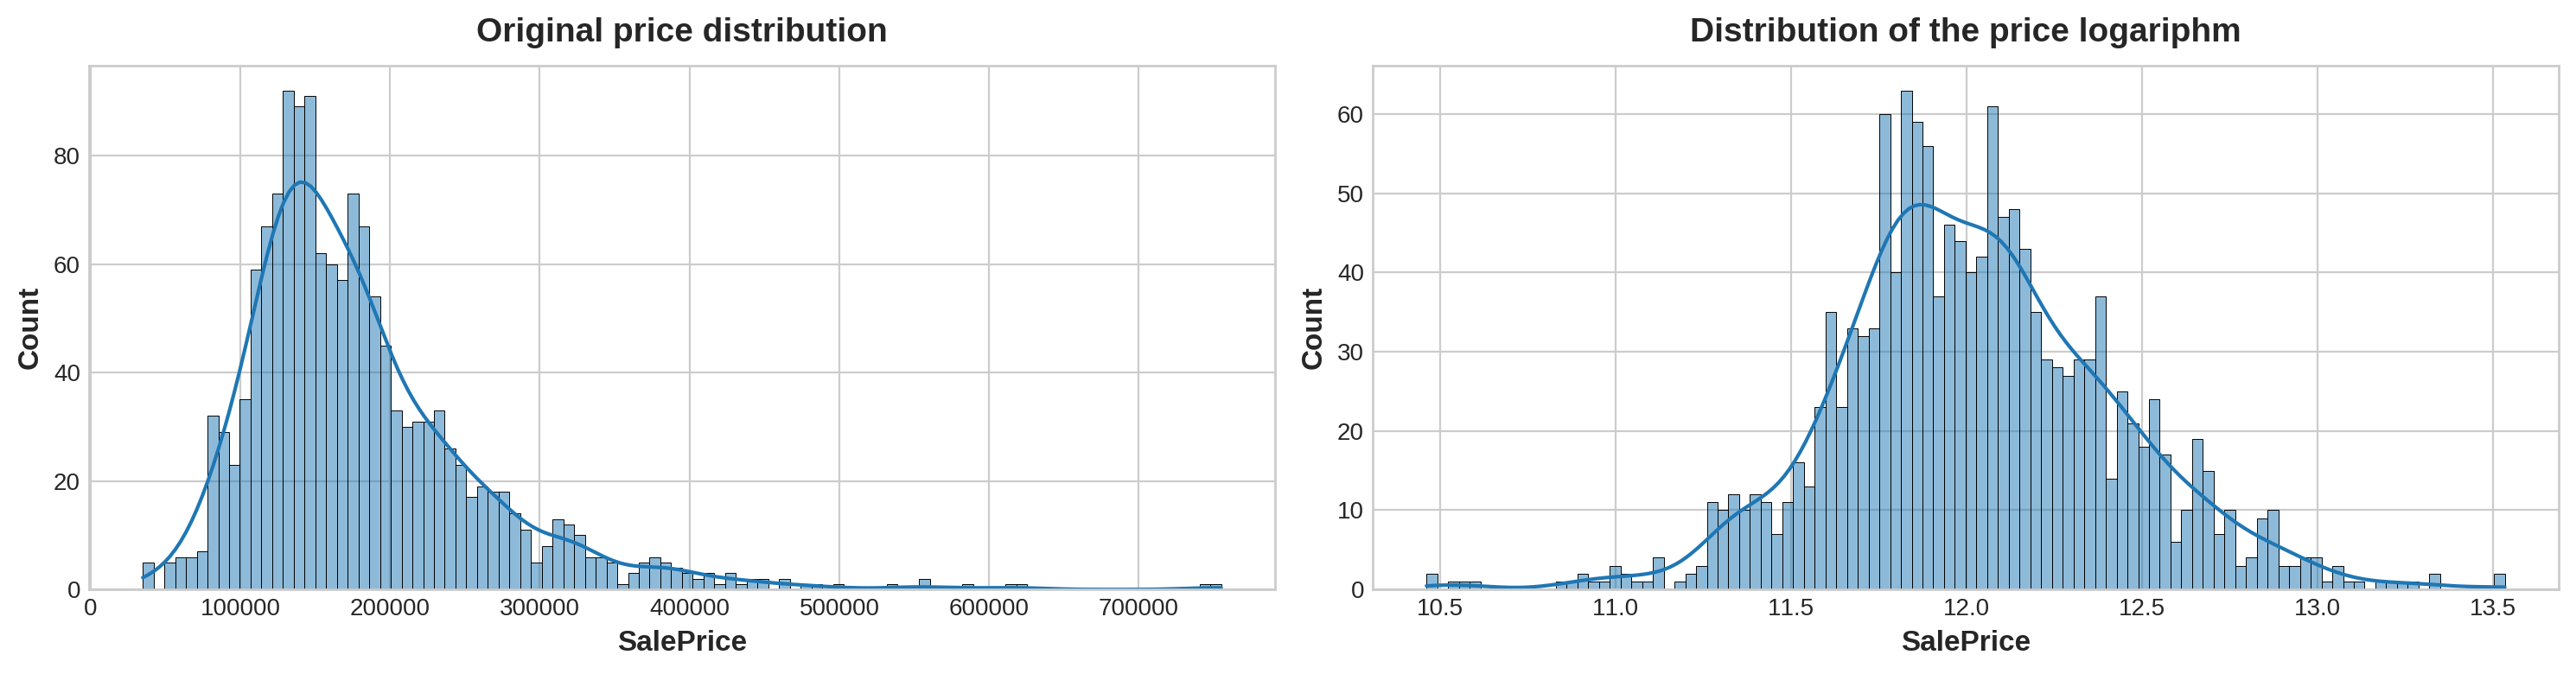

In [21]:
_, axs = plt.subplots(1, 2, figsize = (15,4))
sns.histplot(df_train['SalePrice'], bins=100, kde = True, ax=axs[0])
axs[0].set_title('Original price distribution')
sns.histplot(df_train['SalePrice'].apply(np.log1p), bins=100, kde = True, ax=axs[1])
axs[1].set_title('Distribution of the price logariphm')

Thus, the original sale price distribution is skewed toward zero and has a long tail. To make it more normally distributed, which is usually good for algorithms, let's take the logarithm of the price.

# 2. Ensemble model baseline <a class="anchor" id="h2"></a>

Here 4 tree-based ensemble regression models are considered: XGBoost, lightgbm, sklearn GradientBoostingRegressor and RandomForestRegressor.
I limited my consideration to this type of model because, apart from Neural Networks, they are the most promissing for solving regression problem.
At the first stage, the models will be trained on unmodified features to obtain some baseline allowing to assess the significance of each type of data manipulation.
Actually, the tree-based models are not very sensitive to feature engineering and data preparation, 
so I don't expect further work to significantly improve these baselina results.
But the main goal of this work is not to get the excellent results, but to demonstrate knowledge of various techniques and methods for manipulating data and selecting those that improve the quality of the final model.

In [22]:
def get_data(): 
    X = df_train.copy()
    y = X.pop('SalePrice')    

    # To create a pipeline using sklearn tools without losing accuracy in the case of LGBM regression, 
    # it is needed to convert the categories into a numeric representation.
    X[cat_cols] = X[cat_cols].apply(lambda x: x.cat.rename_categories(range(x.cat.categories.size))) 
    
    return X, y

X, y = get_data()

In [23]:
def score_dataset(X, y, name, model): 
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    
    #name = model_tuple[0]  # model_tuple is tuple of the final estimator name and model itself (pipeline model as usual): (model_name, model)
    #model = model_tuple[1]
    
    XX = X.copy()
    
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    
    #if type(model).__name__ != 'LGBMRegressor':        
    #if name == 'XGBR':    
    #    for colname in X.select_dtypes(["category"]):
    #        XX[colname] = X[colname].cat.codes # Label endoding for XGBR since it does not process the categorical data type.
            
    if name != 'LGBMR':
        for colname in X.select_dtypes(["category"]):
            XX[colname] = X[colname].cat.codes # Label endoding               
    else:
        XX = X.copy() # LGB doesn't need to encode the categorical features
            
    score = cross_val_score(
        model, XX, log_y, cv=5, scoring="neg_mean_squared_error",
        )
      
    score = np.sqrt(-1 * score.mean())
    
    return score

In [24]:
models = [XGBRegressor(),skGBR(),skRFR(),lgb.LGBMRegressor()]
model_names = ['XGBR', 'skGBR', 'skRFR', 'LGBMR']

df_results = pd.DataFrame(columns=[model_names])

In [25]:
for name, model in zip(model_names, models): 
    df_results.loc['base', name] = score_dataset(X,y, name, model)    

In [26]:
df_results

XGBR    skGBR     skRFR     LGBMR
base  0.143511  0.12689  0.140691  0.129894

-------------------

# 3. Feature Utility Score (Mutual information) <a class="anchor" id="h3"></a>

Let's see which features are most related to the target variable based on the amount of [mutual information](https://en.wikipedia.org/wiki/Mutual_information). 

In [27]:
def make_mi_scores(X, y):
    XX = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        XX[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in XX.dtypes]
    mi_scores = mutual_info_regression(XX, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=XX.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    bar_width = scores.sort_values(ascending=True)
    y_coordinates = np.arange(len(scores))
    ticks = list(scores.sort_values(ascending=True).index)
    plt.figure(figsize=(15,15))
    plt.barh(y_coordinates, bar_width)
    plt.yticks(y_coordinates, ticks)
    plt.title("Mutual Information Scores")

In [28]:
X = df_train.copy()
y = X.pop("SalePrice")

mi_scores = make_mi_scores(X, y)
mi_scores[mi_scores > 0].index

Index(['OverallQual', 'Neighborhood', 'GrLivArea', 'YearBuilt', 'LotArea',
       'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtQual', 'KitchenQual',
       'ExterQual', 'FirstFlrSF', 'MSSubClass', 'YearRemodAdd', 'GarageYrBlt',
       'FullBath', 'GarageFinish', 'LotFrontage', 'FireplaceQu', 'GarageType',
       'TotRmsAbvGrd', 'Foundation', 'OpenPorchSF', 'Fireplaces',
       'SecondFlrSF', 'HeatingQC', 'Exterior2nd', 'BsmtFinSF1', 'BsmtFinType1',
       'Exterior1st', 'MSZoning', 'BsmtUnfSF', 'OverallCond', 'WoodDeckSF',
       'MasVnrType', 'MasVnrArea', 'LotShape', 'HouseStyle', 'HalfBath',
       'SaleCondition', 'SaleType', 'GarageCond', 'BsmtExposure', 'GarageQual',
       'BedroomAbvGr', 'CentralAir', 'BsmtCond', 'PavedDrive', 'Electrical',
       'Fence', 'BldgType', 'BsmtFinType2', 'LandContour', 'Alley',
       'ScreenPorch', 'EnclosedPorch', 'KitchenAbvGr', 'ExterCond',
       'Condition1', 'Heating', 'BsmtHalfBath', 'LotConfig', 'RoofStyle',
       'BsmtFinSF2', 'BsmtFu

In [29]:
mi_scores[mi_scores > 0].size

74

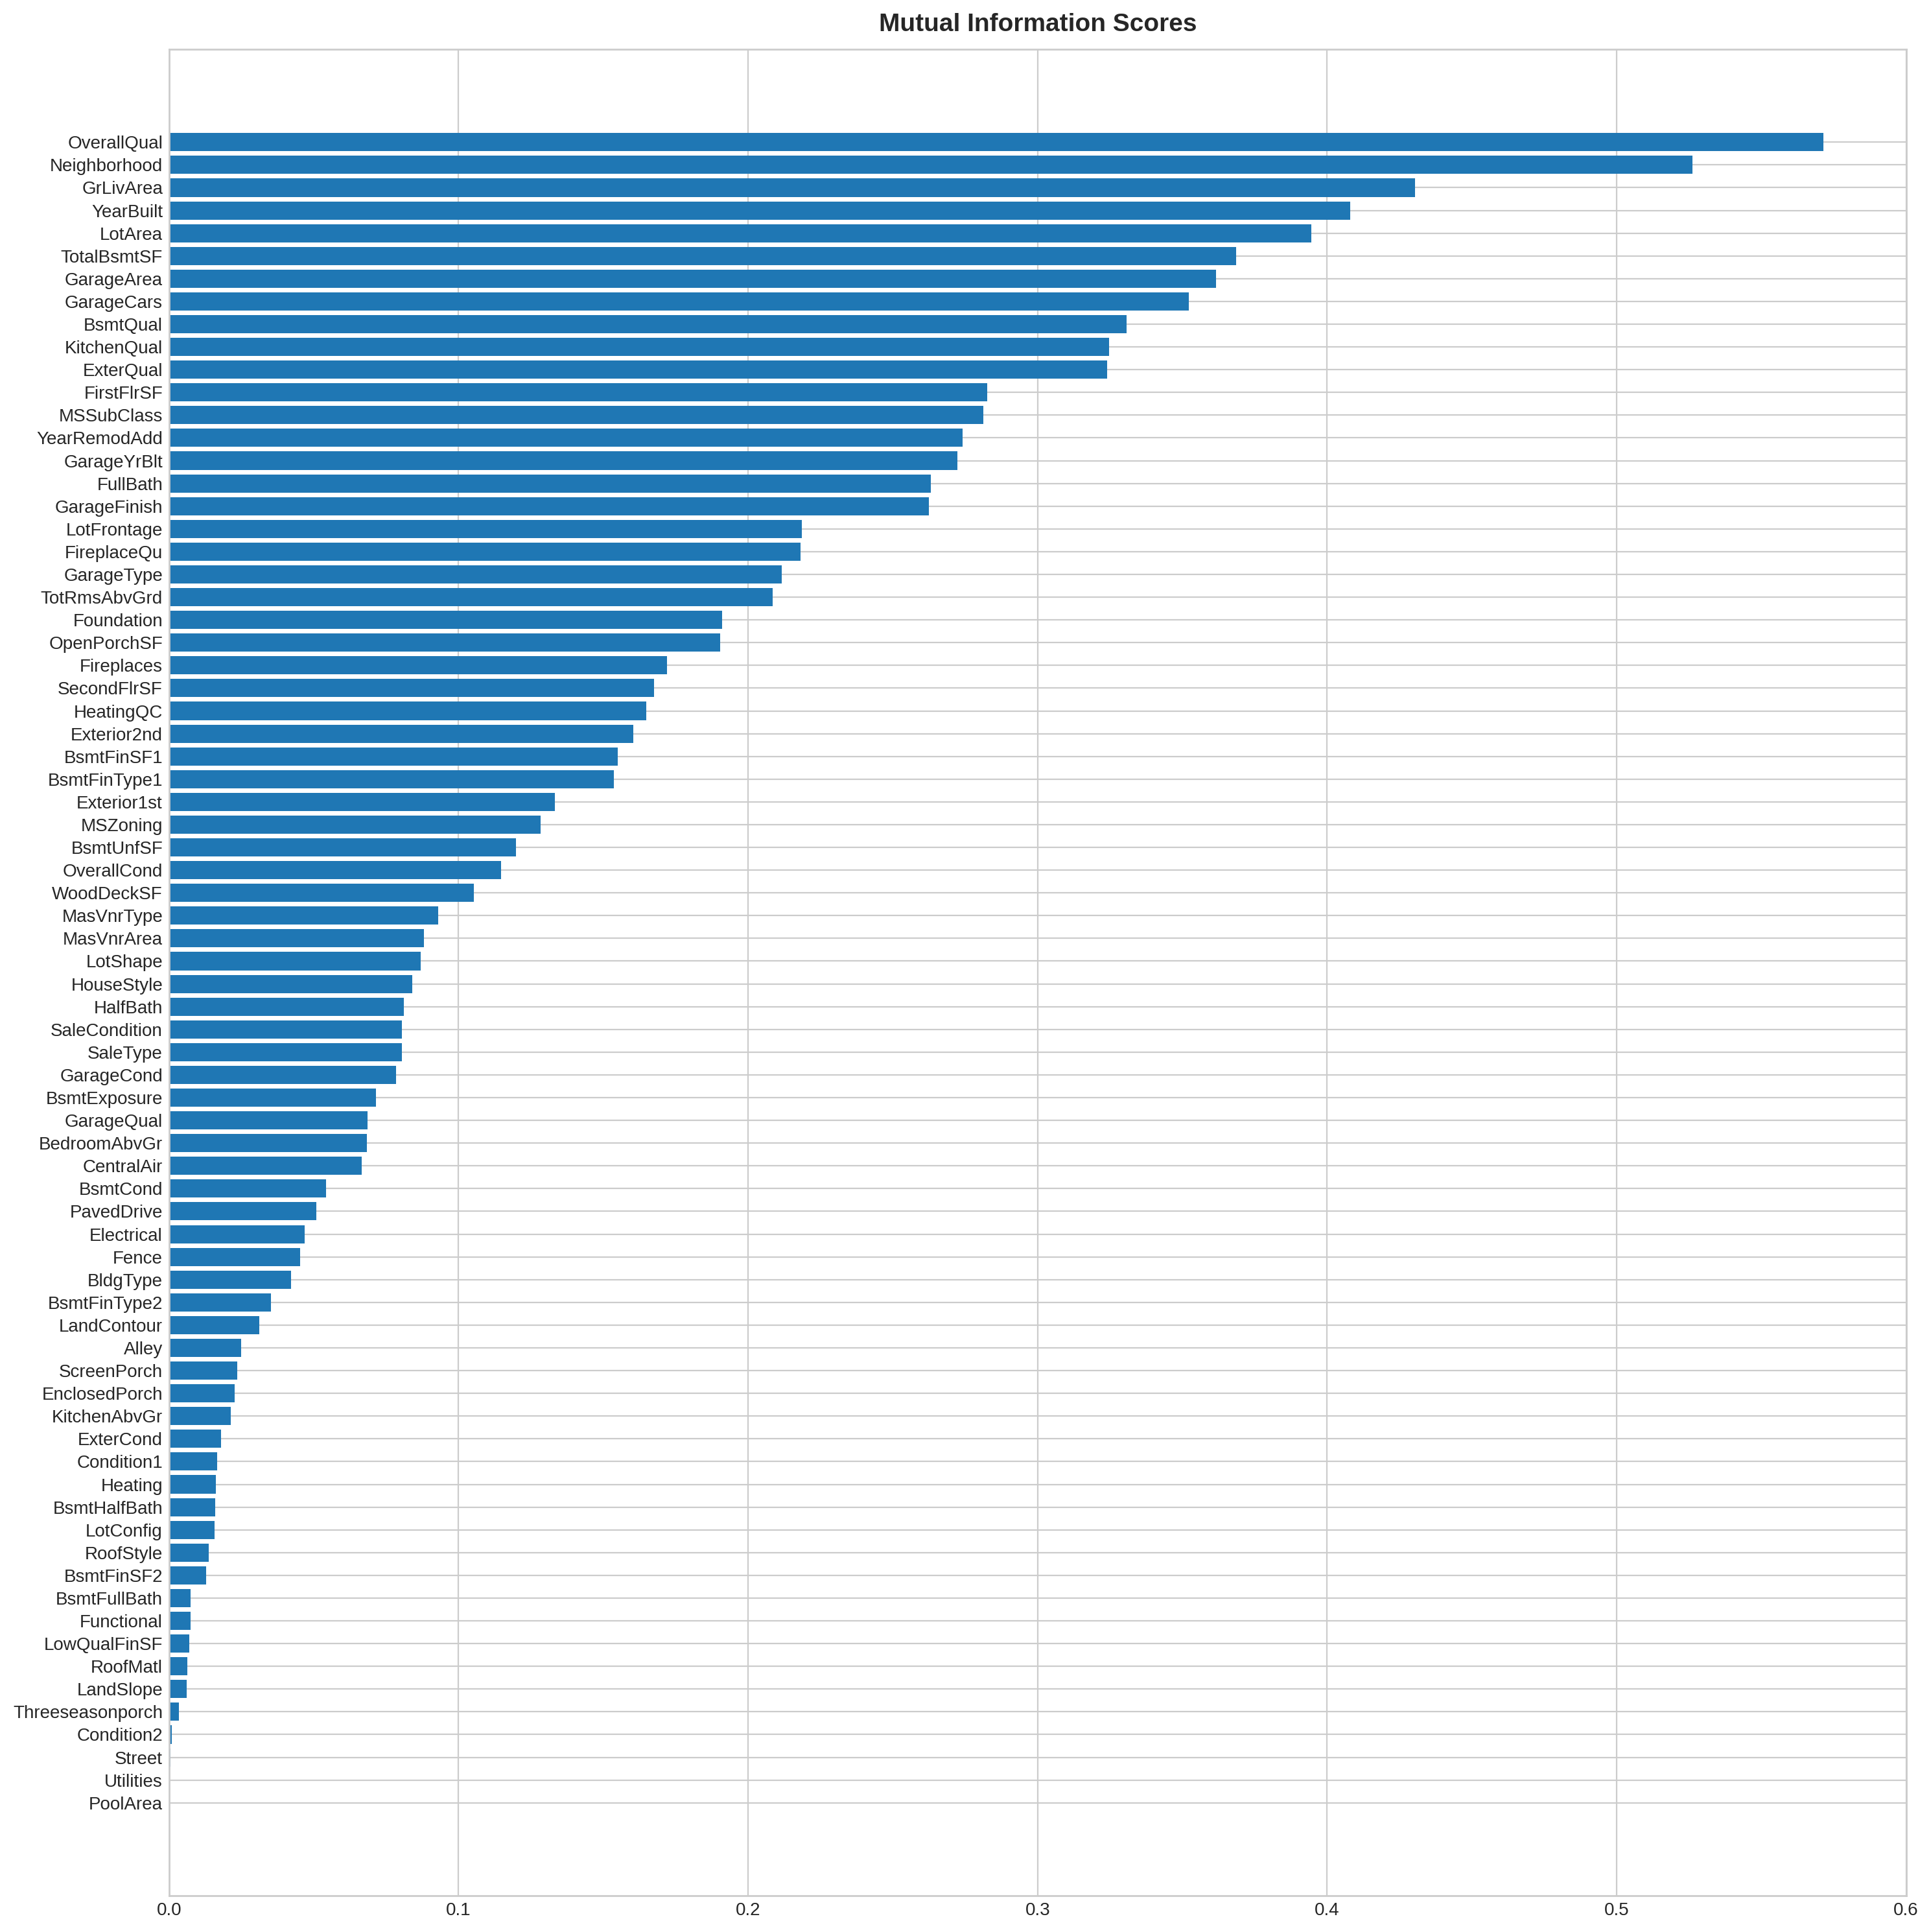

In [30]:
plot_mi_scores(mi_scores[mi_scores > 0])

-------------------

## 3.1 MI filtering in pipeline <a class="anchor" id="h3.1"></a>

In [31]:
class MIEstimator(BaseEstimator):
    def __init__(self, discrete_features='auto', n_neighbors=3, copy=True, random_state=None):
        self.discrete_features = discrete_features
        self.n_neighbors = n_neighbors
        self.copy = copy
        self.random_state = random_state
    

    def fit(self, X, y):
        XX = X.copy()
        #if isinstance(XX, pd.DataFrame):
        #    for colname in XX.select_dtypes(["object", "category"]):
        #        XX[colname], _ = XX[colname].factorize()    
        #    self.discrete_features = [pd.api.types.is_integer_dtype(t) for t in XX.dtypes]
            
        self.feature_importances_ = mutual_info_regression(XX, y, discrete_features=self.discrete_features, 
                                                            n_neighbors=self.n_neighbors, 
                                                            copy=self.copy, random_state=self.random_state)
    
    def __call__(self, X, y):
        self.fit(X,y)
        return self.feature_importances_
        

In [32]:
X, y = get_data()
log_y = np.log(y)

In [33]:
discrete_cols = X.select_dtypes('int').columns.to_list() + cat_cols
discrete_mask = [True if x in discrete_cols else False for x in X.columns]
mie = MIEstimator(discrete_features=discrete_mask)

In [34]:
num_non_zero = np.sum(mie(X, log_y) > 0)
num_non_zero

75

In [35]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, y, model, gs_params):
    # Label encoding for categoricals
    #
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    XX = X.copy()
    
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    log_y = np.log(y)
    
    if type(model).__name__ != 'LGBMRegressor':
        for colname in X.select_dtypes(["category"]):
            XX[colname] = X[colname].cat.codes # Label endoding               
    else:
        XX = X.copy() # LGB doesn't need to encode the categorical features
        
    gs = GridSearchCV(estimator=model, param_grid=gs_params, refit=True,
                      scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=0)
    
    gs.fit(XX, log_y)
    
    #scores = [gs.cv_results_[f'split{i}_test_score'][gs.best_index_] for i in range(5)]
    #print('scores = {}, \nmean score = {:.5f} +/- {:.5f} \
    #       \nbest params = {}'.format(scores,
    #                                  gs.cv_results_['mean_test_score'][gs.best_index_],
    #                                  gs.cv_results_['std_test_score'][gs.best_index_],
    #                                  gs.best_params_))
  
    return gs

In [36]:
gs_mi_params = {'mi_selector__k': range(10,80)}
gs_res = {}

mi_pipe_step = ('mi_selector', SelectKBest(mie))

for name, model in zip(model_names, models):
    pipe_model = Pipeline([mi_pipe_step, (name, model)])   
    gs = grid_search(X, y, pipe_model, gs_params=gs_mi_params)
    best_score = np.sqrt(-1*gs.best_score_)
    best_n = gs.best_params_['mi_selector__k']
    gs_res[name] = gs
    print(f'{name} = {best_score:.4f};\t n = {best_n}')

XGBR = 0.1392;	 n = 56
skGBR = 0.1260;	 n = 68
skRFR = 0.1374;	 n = 69
LGBMR = 0.1323;	 n = 67


In [37]:
df_results

XGBR    skGBR     skRFR     LGBMR
base  0.143511  0.12689  0.140691  0.129894

The above results show some minor improvements in model performance when removing features with low mutual information score. However, this does not apply to LightGBM regression. The latter can be explained by the ability of the LGBT algorithm to process the information from the structure of categorical features contained in the pandas data frame. Inside the pipeline design model, this information is lost, since the data is grouped and transmitted into numpy arrays.
Therefore, next we will try to remove the features with low MI score manually before regression.

It will be more convenient to use the entire available dataset for evaluation. 
To do this, let us assume that the MI assessment of features obtained for the entire dataset will not differ significantly from the assessment for the training set only (80% of entire dataset). Otherwise we would get a data leakage. 

In [38]:
''' To remove features with 0 MI'''

def drop_uninformative(df, mi_scores, mi_min = 0.0):
    return df.loc[:, mi_scores > mi_min]

In [39]:
mi_score = make_mi_scores(X,y) #pd.Series(mie(X, log_y), name='mi_score', index=X.columns).sort_values(ascending=False)

In [40]:
'''We will use 60 features as a tread off of the results obtained previously'''
mi_min_val = mi_score[60]

In [41]:
X, y = get_data()

X = drop_uninformative(X, mi_score, mi_min=mi_min_val)

for model, name in zip(models, model_names): 
    df_results.loc['no_zero_MI', name] = score_dataset(X,y, name, model)

In [42]:
df_results

XGBR     skGBR     skRFR     LGBMR
base        0.143511   0.12689  0.140691  0.129894
no_zero_MI  0.139175  0.127734  0.139115  0.129619

# 4. Feature engineering  <a class="anchor" id="h4"></a>

## 4.1 Math feature transformation  <a class="anchor" id="h4.1"></a>

### 4.1.1 Data normalization  <a class="anchor" id="h4.1.1"></a>

As with the Sale Price, some numerical features have a skewed or squeezed distribution, and normalizing them, for example by taking a logarithm or Box-Cox transfomation, can improve the regression results.

In [43]:
'''The plots help to figure out which features need to be normalized by taking a logarithm'''

numeric_cols = df_train.select_dtypes(['number']).columns
fig, axs = plt.subplots(len(numeric_cols), 2, figsize=(14, 3*len(numeric_cols)))

for i, col in enumerate(numeric_cols):   
    sns.kdeplot(df_train[col], fill=True, ax=axs[i,0])
    sns.kdeplot(df_train[col].apply(np.log1p), fill=True, ax=axs[i,1])

In [44]:
'''So based on the above graphs, I manually select the numeric features for the logarithmic transformation.'''

cols_to_log1p = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','FirstFlrSF','SecondFlrSF','WoodDeckSF','OpenPorchSF']

mi_score[cols_to_log1p] # Look at MI scores for these features

LotFrontage    0.218588
LotArea        0.394468
MasVnrArea     0.088054
BsmtFinSF1     0.154940
BsmtFinSF2     0.012719
BsmtUnfSF      0.119885
TotalBsmtSF    0.368536
FirstFlrSF     0.282503
SecondFlrSF    0.167590
WoodDeckSF     0.105387
OpenPorchSF    0.190266
Name: MI Scores, dtype: float64

### 4.1.2 Accumulation of various transformation of numerical features <a class="anchor" id="h4.1.2"></a>

Here we will introduce functions for each math transformation of numerical features and later, having applied them all, we will get a new dataset, and with it the ability to assess these transformations.

In [45]:
'''Select some features that describe various areas, which we will try to improve by taking the square root.'''

area_feat = ['GrLivArea','WoodDeckSF','MasVnrArea','TotalBsmtSF']
mi_score[area_feat]

GrLivArea      0.430395
WoodDeckSF     0.105387
MasVnrArea     0.088054
TotalBsmtSF    0.368536
Name: MI Scores, dtype: float64

In [46]:
'''
The following feature transformations are performed row by row and thus do not contaminate the validation data set.
I.e. they do not lead to data leakage and can be applied to the entire dataset prior to cross-validation.
'''
# Label encoding 
def label_encode(df):
    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

# Some math transformations. Most of them are taken from the Kaggle course, but after that the most valuable ones were selected.
def mathematical_transforms(df):
    X = pd.DataFrame()  # dataframe to hold new features
    X["LivLotRatio"] = df.GrLivArea / df.LotArea
    X["Spaciousness"] = (df.FirstFlrSF + df.SecondFlrSF) / df.TotRmsAbvGrd
    # This feature ended up not helping performance and were excluded:
    #X["TotalOutsideSF"] = df.WoodDeckSF + df.OpenPorchSF + df.EnclosedPorch + df.Threeseasonporch + df.ScreenPorch
    #X['Overall_QualCond'] = df[['OverallQual','OverallCond']].replace({'None':0}).to_numpy().prod(axis=1)
    return X

# Logarithm transform
def log1p_transform(df, cols):
    X = df[cols].apply(np.log1p)
    X.columns = [col + '_log1p' for col in cols]
    return X

# Taking square root of some area features (also inspired by Kaggle course): 
def area_root(df, cols):
    X = df[cols].apply(np.sqrt)
    X.columns = [col + '_sqrt' for col in cols]
    return X

# Interation of 2 features (from Kaggel course)
def interactions(df):
    X = pd.get_dummies(df.BldgType, prefix="Bldg")
    X = X.mul(df.GrLivArea, axis=0)
    return X

# One-hot encoding: generally meaningless for tree-based ensemble models.
def onehot(df, num, onehot_cols = None):
    X = pd.DataFrame(index=df.index)
    if not onehot_cols:
        onehot_cols = [col for col in df.select_dtypes(['category']) if (df[col].nunique() < num) & (df[col].nunique() > 2)]
    for col in onehot_cols:
        X = X.join(pd.get_dummies(df[col], prefix=col))
    return X #, onehot_cols

def counts(df):
    X = pd.DataFrame()
    X["PorchTypes"] = df[[
        "WoodDeckSF",
        "OpenPorchSF",
        "EnclosedPorch",
        "Threeseasonporch",
        "ScreenPorch",
    ]].gt(0.0).sum(axis=1)
    return X

In [47]:
''' 
The next transformation aggregate the statistics of some important features for different Neighborhoods.
In this case, the transformation may lead to data leakage, so it cannot be applied to the entire data set at once 
and therefore cannot be written as a simple function like those described above.
It needs to be designed as a transformer that implements fit() and transform() methods.

Actually, the transformer can be generalized to aggregate statistics for various statisctis, but  
In fact, the generalizing the transformer to the functional for aggregating a wide variety of this kind statistics is quite straightforward. 
However, in this work I did not plan to use this and, to save time, it is performed in the simplified design.
'''

class GroupTransform(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        X_map = X.groupby("Neighborhood")[["GrLivArea","LotArea"]].agg(['median','min','std','count'])
        X_map.columns = ['Nhbd' + '_'.join(col) for col in X_map.columns]
        self.X_map = X_map.iloc[:,:-1]
        return self
        
    def transform(self, X, y=None):
        self.X_ = X.copy()
        self.X_ = self.X_.join(self.X_map, on='Neighborhood').fillna(0)
        
        #self.X_.loc[:,"MedNhbdGrArea"] = X.Neighborhood.map(self.X_map.loc[:,('GrLivArea', 'median')]).fillna(0)
        #self.X_.loc[:,"MedNhbdLotArea"] = X.Neighborhood.map(self.X_map.loc[:,('LotArea', 'median')]).fillna(0)
        #self.X_.loc[:,"MinNhbdGrArea"] = X.Neighborhood.map(self.X_map.loc[:,('GrLivArea', 'min')]).fillna(0)
        #self.X_.loc[:,"MinNhbdLotArea"] = X.Neighborhood.map(self.X_map.loc[:,('LotArea', 'min')]).fillna(0)
        #self.X_.loc[:,"StdNhbdGrArea"] = X.Neighborhood.map(self.X_map.loc[:,('GrLivArea', 'std')]).fillna(0)
        #self.X_.loc[:,"StdNhbdLotArea"] = X.Neighborhood.map(self.X_map.loc[:,('LotArea', 'std')]).fillna(0)
        #self.X_.loc[:,"CountNhbdGrArea"] = X.Neighborhood.map(self.X_map.loc[:,('GrLivArea', 'count')]).fillna(0)
        #self.new_cols = ['MedNhbdGrArea','MedNhbdLotArea','MinNhbdGrArea','MinNhbdLotArea','StdNhbdGrArea','StdNhbdLotArea','CountNhbdGrArea']
        return self.X_
    
    #def fit_transform(self, X):
    #    return self.fit(X).transform(X)
    

<AxesSubplot:>

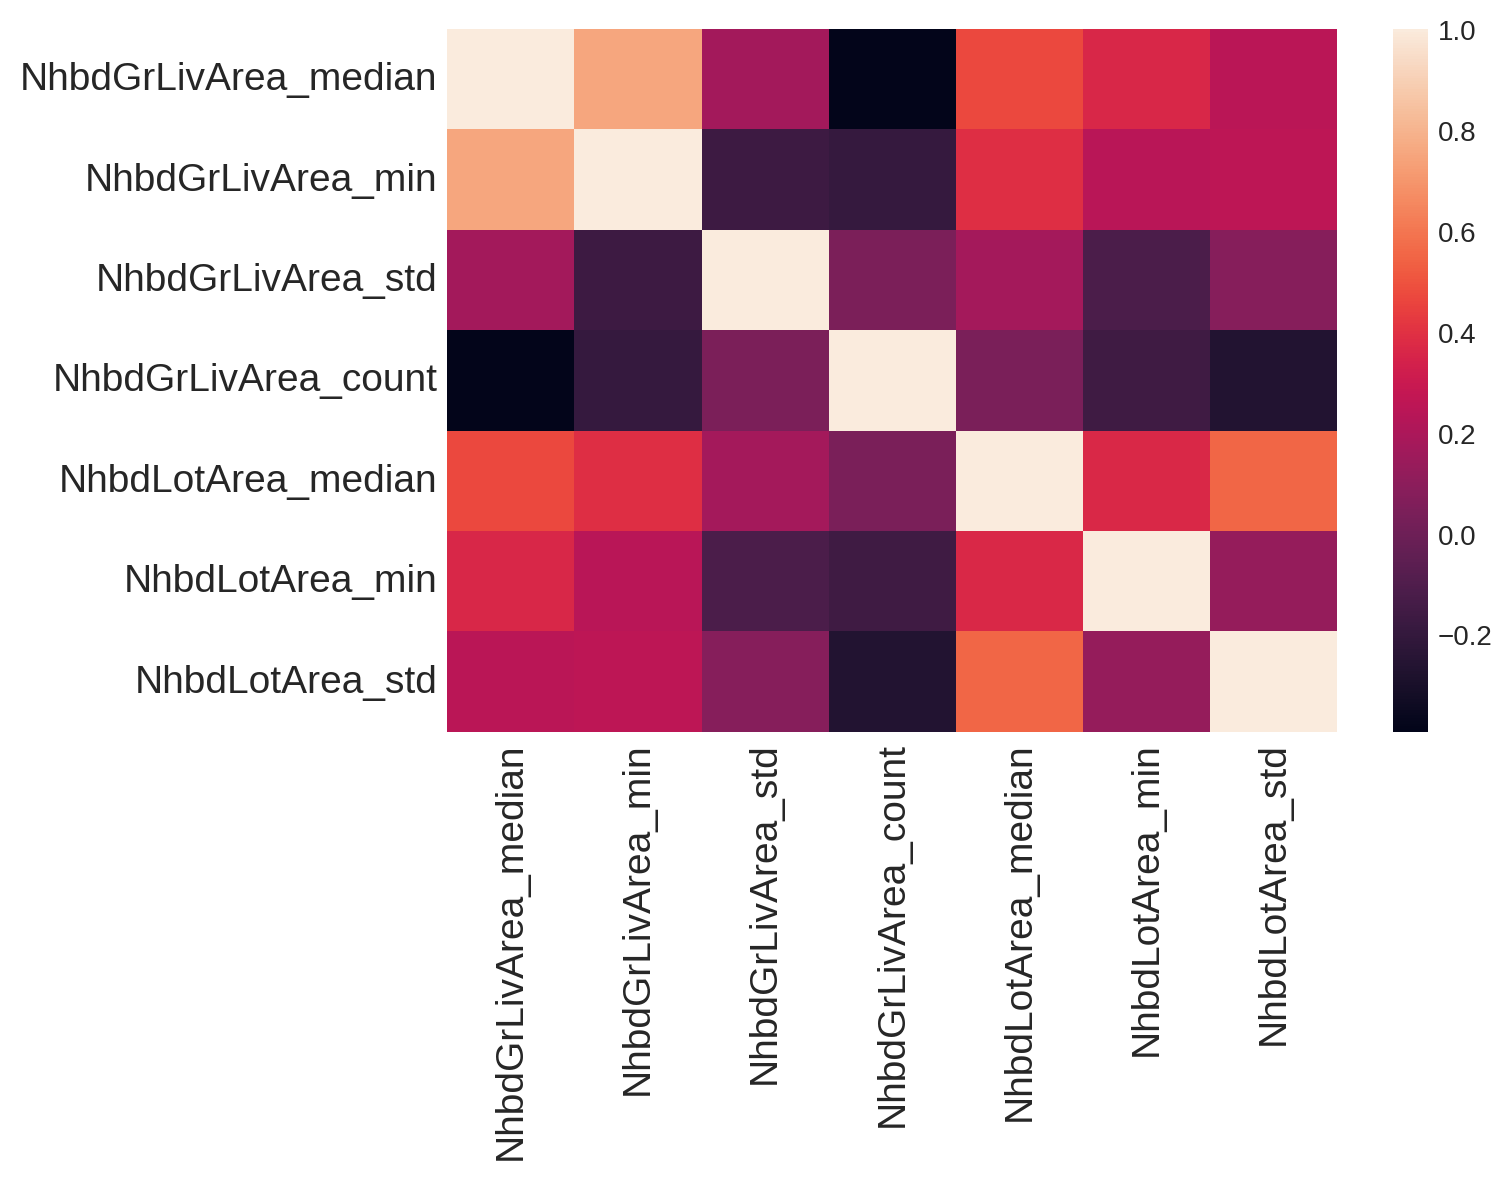

In [48]:
# Evaluate the correlation of the obtained Neighborhood group characteristics
gpt = GroupTransform()
new_feat = gpt.fit_transform(X)[gpt.X_map.columns]

plt.figure(figsize=(8,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
sns.heatmap(new_feat.corr())


In [49]:
'''Function to collect all the above transformations applied to the entire dataset before cross-validation.'''

def create_features(df):
    #X = df.copy()
    #y = X.pop("SalePrice")
    X, y = get_data()
    X = X.join(mathematical_transforms(X))
    X = X.join(log1p_transform(X,cols_to_log1p))
    X = X.join(area_root(X,area_feat))
    X = X.join(interactions(X))
    #X = X.join(onehot(X,10))
    X = X.join(counts(X))    
    return X, y

In [50]:
gp = GroupTransform()

# Applying above transformations to the dataset:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
new_features_mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, new_features_mi_scores, mi_min=mi_min_val)

# Evaluate the model
for model, name in zip(models, model_names): 
    pipe = Pipeline(steps=[('gp', gp), (name, model)])        
    df_results.loc['math_transform', name] = score_dataset(X,y, name, pipe)

In [51]:
df_results

XGBR     skGBR     skRFR     LGBMR
base            0.143511   0.12689  0.140691  0.129894
no_zero_MI      0.139175  0.127734  0.139115  0.129619
math_transform  0.136766  0.125206  0.138411  0.129726

Here we can say, that by adding the new features we have slightly improved the models under consideration.

### 4.1.3 Removing correlating features <a class="anchor" id="h4.1.3"></a>

Let's remove highly correlated features which usually only clutter the dataset and can even decrease the model performance. 

In [52]:
class DropCorr(BaseEstimator,TransformerMixin):
    def __init__(self, crit_corr = 0.9):
        self.crit_corr = crit_corr        
        
    def fit(self, df, y = None): 
        
        X_ = df.copy()
        
        for colname in X_.select_dtypes(["category"]):
            X_[colname] = X_[colname].cat.codes
        
        corr_matrix = X_.corr().abs()        
       
        half_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        cols_pairs = half_corr[half_corr > self.crit_corr].stack().index.to_list()
    
        self.cols_to_drop = [make_mi_scores(X_[list(col)],y).idxmin() for col in cols_pairs]
        
        return self
    
    def transform(self, df, y = None):        
        return df.drop(self.cols_to_drop, axis=1)        
    

In [299]:
'''Let's find the best correlation values for each model using ordinary search'''

drop_results = pd.DataFrame(index = df_results.columns, columns=['score','crit_corr'])
drop_results.score = df_results.iloc[-1,:]
drop_results.crit_corr = None

for model, name in zip(models, model_names):
    for corr in np.arange(0.8,1,0.01):
            
        X, y = create_features(df_train)
            
        mi_scores = make_mi_scores(X, y)
        X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)
            
        pipe = Pipeline(steps=[
            ('gp',gp),
            ('drop_corr', DropCorr(crit_corr=corr)),
            (name, model)
        ])
            
        score = score_dataset(X,y, name,pipe)
            
        if score < drop_results.loc[name,'score'].values[0]:
            drop_results.loc[name,:] = score, corr                
    

In [300]:
drop_results

score crit_corr
XGBR   0.135396      0.95
skGBR  0.124789      0.98
skRFR   0.13438      0.87
LGBMR  0.129145      0.96

It can be seen that in this case the optimal correlation parameters are close to the default ones. 
Since we are not dealing with a finite set of features, for simplicity we will leave the default values: crit_corr = 0.9.

In [53]:
# Applying above transformations to the dataset:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()), 
        ('drop_corr', DropCorr()),
        (name, model)])        
    
    df_results.loc['no_corr', name] = score_dataset(X,y, name, pipe)

In [54]:
df_results

XGBR     skGBR     skRFR     LGBMR
base            0.143511   0.12689  0.140691  0.129894
no_zero_MI      0.139175  0.127734  0.139115  0.129619
math_transform  0.136766  0.125206  0.138411  0.129726
no_corr         0.135464  0.125707  0.137078  0.129179

As it can be seen, removing correlated features can slightly improve the regression results of some models. 
So we'll keep this procedure in the data preparation pipeline.

-----------------

## 4.2 k-Means clustering  <a class="anchor" id="h4.2"></a>

k-Means is a well-known data clustering algorithm that can be used to create additional features that can improve the model performance.

### 4.2.1 Cluster labels <a class="anchor" id="h4.2.1"></a>

First, let’s visually assess the possibility of classifying some basic features in general and the approximate number of clusters in this case.

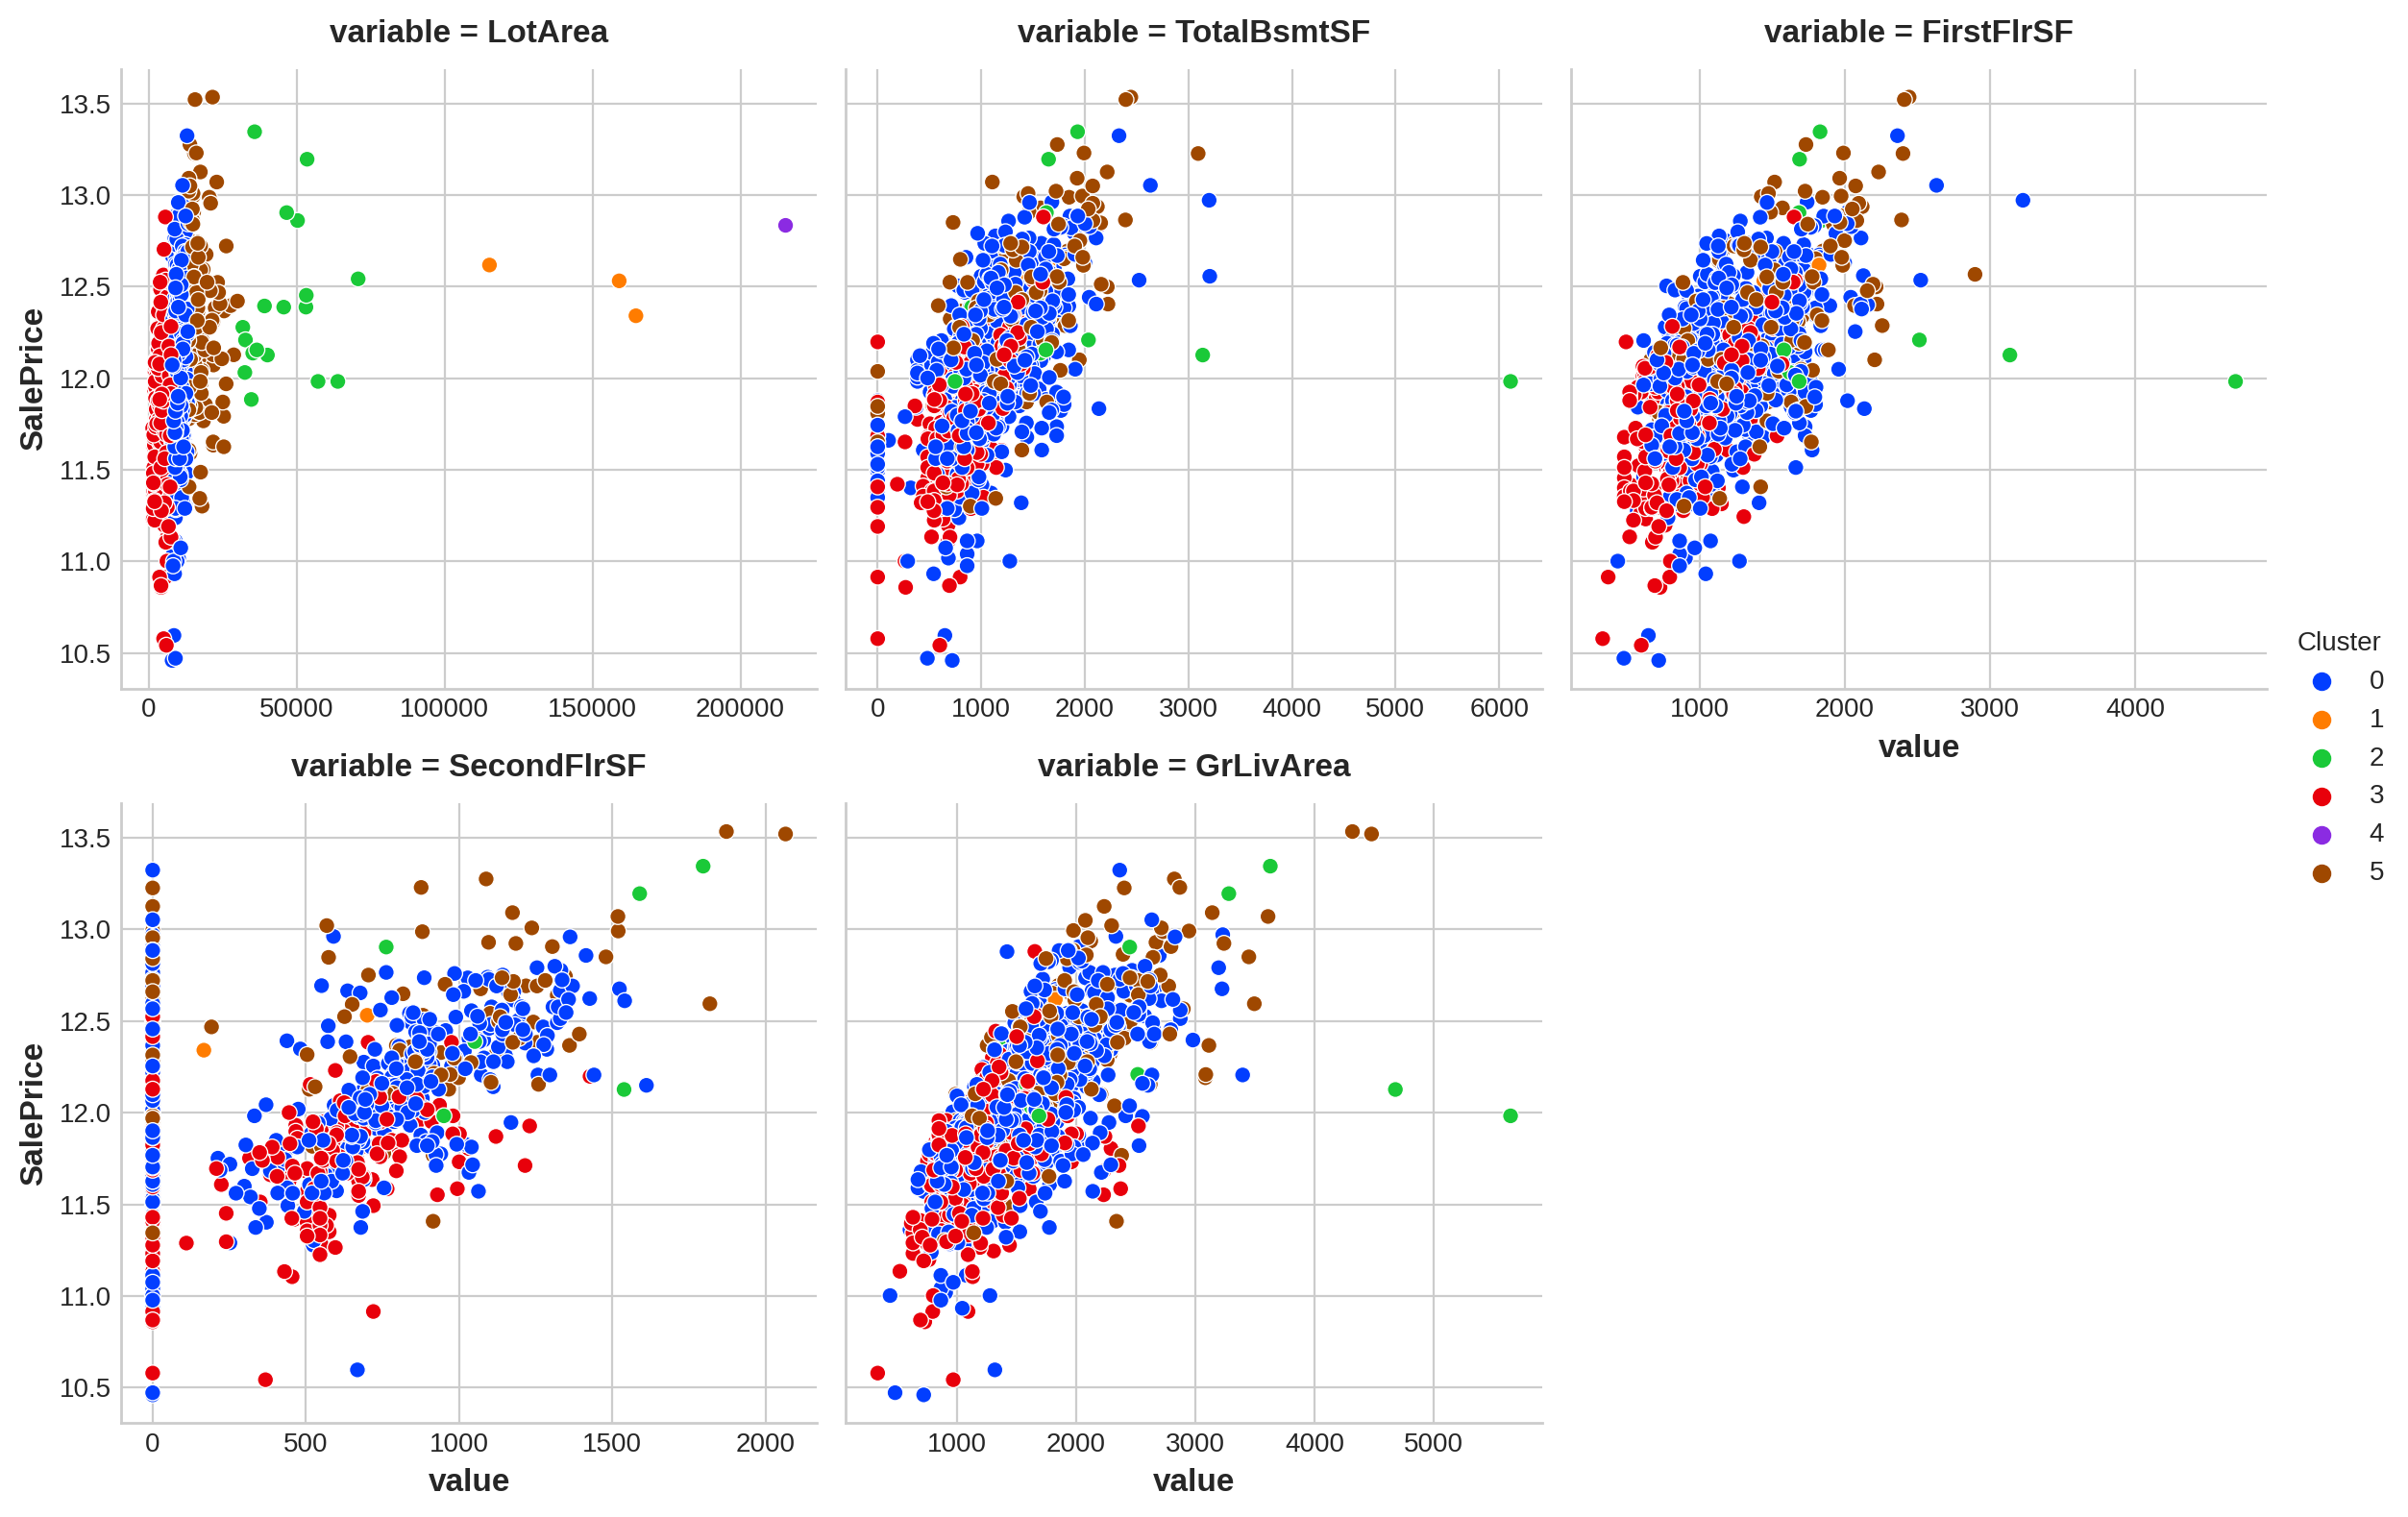

In [55]:
Xy, y = get_data()

cluster_features_basic = [
    "LotArea",
    "TotalBsmtSF",
    "FirstFlrSF",
    "SecondFlrSF",
    "GrLivArea",
]

kML = KMeans(n_clusters=6, n_init=50, random_state=42)
Xy["Cluster"] = kML.fit_predict(Xy[cluster_features_basic], np.log(y))
Xy["SalePrice"] = np.log(y)
sns.relplot(
    x="value", y="SalePrice", hue="Cluster", col="variable",
    height=4, aspect=1, facet_kws={'sharex': False}, col_wrap=3,
    palette="bright",
    data=Xy.melt(
        value_vars=cluster_features_basic, id_vars=["SalePrice", "Cluster"],
    ),
);

In [56]:
def cluster_inertia(df, features, cluster_range=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    inertia = []
    
    for k in range(1, class_range):
        kmeans = KMeans(n_clusters=k,  n_init=50, random_state=0).fit(X_scaled)
        inertia.append(np.sqrt(kmeans.inertia_))
   
    return inertia

CPU times: user 7min 14s, sys: 13.2 s, total: 7min 27s
Wall time: 29.8 s


Text(0, 0.5, '$J(C_k)$')

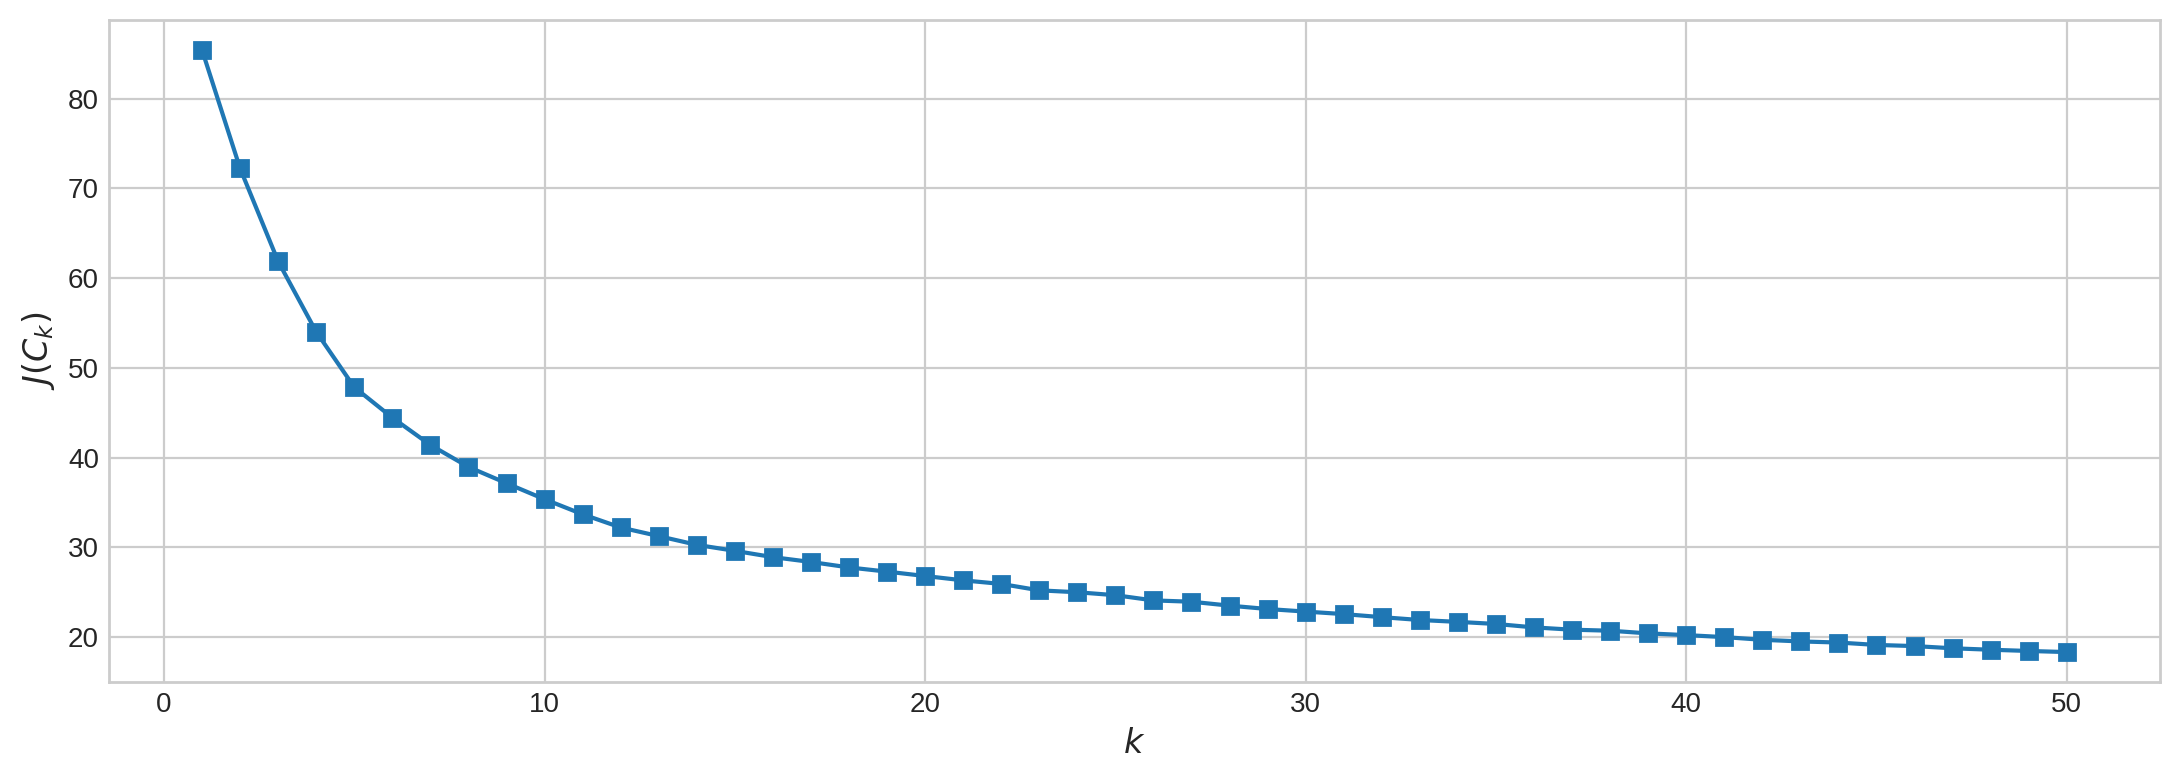

In [57]:
%%time 
class_range = 51

X, y = get_data()

#cluster_features = X.loc[:,cluster_features_basic].select_dtypes('number').columns    
inertia = cluster_inertia(X, cluster_features_basic, class_range)

plt.plot(range(1, class_range), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

So, for the features listed in cluster_features_basic, the approximate reasonable number of clusters is about 10.

Next, let's check whether this provides any improvements for the models under consideration. 

In [58]:
'''
The following class produces the KMeans labels as a feature transformation to be able to apply in pipeline. 
Perhaps less general, but simpler way to disign it with additional claa parameter defining the required columns
and standart scalling precedure inside fit method. 
But, for demonstration, this will be solved via redefining of ColumnTransformer to yield a DataFrame. 

The following class produces KMeans labels as feature transformations that can be performed in a pipeline.
Perhaps a less general, but simpler way to implement it is to add an additional class parameter defining 
the columns for the transformation, as well as a standard scaling procedure inside the fitting method. 
However, mailny for the sake of demonstration, this task will be solved by extendign the performance of 
the ColumnTransformer class to produce a DataFrame object as its output.
'''

class KMeansLabels(KMeans): 
    #def __init__(self,**kwargs):
        #super(KMeansLabels, self).__init__(**kwargs)
                    
    def transform(self, data, y = None):
        #labels = super(KMeansLabels, self).predict(data, y)        
        labels = self.predict(data, y)
        #return np.concatenate((np.array(data), labels.reshape(-1,1)), axis=1)
        return np.nan_to_num(labels.reshape(-1,1), nan=self.n_clusters+1)
        
    def fit_transform(self, data, y=None):
        #labels = super(KMeansLabels, self).fit_predict(data, y)        
        labels = self.fit_predict(data, y)
        #return np.concatenate((np.array(data), labels.reshape(-1,1)), axis=1)        
        return np.nan_to_num(labels.reshape(-1,1), nan=self.n_clusters+1)

In [59]:
'''
Adapted with some modifications from 
https://www.kaggle.com/code/karlkuprian/step-by-step-pipeline-with-pandas-dataframes
'''

class df_ColumnTransformer(ColumnTransformer):
    """
    Tested with: SimpleImputer, OneHotEncoder, OrdinalEncoder
    Applies transformers to columns of an array or pandas DataFrame.
    In contrast to the sklearn ColumnTransfromer, this transfomer returns a pandas Dataframe

    This estimator allows different columns or column subsets of the input
    to be transformed separately and the features generated by each transformer
    will be concatenated to form a single feature space.
    This is useful for heterogeneous or columnar data, to combine several
    feature extraction mechanisms or transformations into a single transformer.
    """
    
    def fit_transform(self, X, *args, **kwargs):
        ColumnTransformer.fit_transform(self, X)
        return df_ColumnTransformer.transform(self, X, *args, **kwargs)

    def transform(self, X, *args, **kwargs):

        ret_df = pd.DataFrame(index=X.index) 
        
        for row in self.transformers_: # row includes all information for one transformer step.
            
            title = row[0] # transformation title
            transformer = row[1] # tranformer to be applied
            lst_of_cols = row[2] #columns to be transformed with this transformer
            
            if isinstance(transformer, str):
                # passthrough other elments if passthrough is set
                if transformer == 'passthrough':
                    cols = []
                    for index in lst_of_cols:
                        if isinstance(index, int):
                            cols.append(X.columns[index])
                        else:
                            cols.append(index)
                            
                    ret_df = pd.concat([ret_df, X[cols]], axis=1)
                    
            else:
                
                transformed = transformer.transform(X[lst_of_cols]) 
                
                if isinstance(transformed, (pd.DataFrame, pd.Series)):                     
                    ret_df = pd.concat([ret_df, transformed], axis=1)                    
                else:                     
                    cols = [] 
                    num_trans_cols = transformed.shape[1]
                    
                    if num_trans_cols == len(lst_of_cols):
                        cols = [col + '_' + title for col in lst_of_cols]
                    elif num_trans_cols == 1:
                        cols = [title]
                    elif (num_trans_cols > len(lst_of_cols)) and (num_trans_cols % len(lst_of_cols) == 0): 
                        cols = [lst_of_cols[i//len(lst_of_cols)] + '_' + str(i) for i in range(1,num_trans_cols+1)]
                    else:
                        cols = [title + '_' + str(i) for i in range (1,num_trans_cols+1)]
                        
                    # if tranformer returns ndarray convert to Dataframe
                    if isinstance(transformed, np.ndarray):
                        temp_df = pd.DataFrame(transformed, index=X.index, columns=cols)
                    else:
                    # if sparse matrix is returned by transformer
                        temp_df = pd.DataFrame.sparse.from_spmatrix(transformed, index=X.index, columns=cols)
                        temp_df = temp_df.sparse.to_dense()
                            
                    ret_df = pd.concat([ret_df, temp_df], axis=1)                        

        return ret_df   


In [61]:
cluster_features = X.loc[:,new_features_mi_scores > 0.35].select_dtypes('number').columns

X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

# Create the pipe for labeling by KMeans: 
kML = KMeansLabels(n_clusters=15, n_init=50, random_state=42)
klabels_pipe = Pipeline(steps=[('scaler', StandardScaler()),('kML',kML)])

klab_coltrans_no_origin = df_ColumnTransformer(transformers=[('kl_pipe', klabels_pipe, cluster_features_basic)], remainder='passthrough')
klab_coltrans = df_ColumnTransformer(transformers=[('kl_pipe', klabels_pipe, cluster_features_basic), ('keep_origin', 'passthrough', cluster_features_basic)], remainder='passthrough')

# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()), 
        ('klab', klab_coltrans_no_origin),       
        ('drop_corr', DropCorr()),        
        (name, model),
    ])        
    df_results.loc['KMeans_labels_no_origin', name] = score_dataset(X,y, name, pipe)
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()), 
        ('klab', klab_coltrans),       
        ('drop_corr', DropCorr()),        
        (name, model),
    ])        
    df_results.loc['KMeans_labels', name] = score_dataset(X,y, name, pipe)


In [62]:
df_results

XGBR     skGBR     skRFR     LGBMR
base                     0.143511   0.12689  0.140691  0.129894
no_zero_MI               0.139175  0.127734  0.139115  0.129619
math_transform           0.136766  0.125206  0.138411  0.129726
no_corr                  0.135464  0.125707  0.137078  0.129179
KMeans_labels_no_origin  0.135885  0.126702  0.137101   0.12991
KMeans_labels            0.136587   0.12637  0.137172  0.129909

Thus, at this stage it is difficult to say whether this method can improve the results of the models under consideration. 
Thus, it is difficult to say whether it is possible to improve the performance of the models under consideration using additional KMeans labels. 
The maximum that was achieved by manual search was approximately the same error value as in previous case.
This result is quite expected since we use tree-based models that naturally divide the data into clusters during the training process.
Therefore, this model will not be used further when preprocessing data in the pipeline.

### 4.2.2 Cluster distance <a class="anchor" id="h4.2.2"></a>

For accuracy, we will also try to consider as an additional feature, instead of the cluster number, the distance from each point to its center.

In [63]:
cluster_features = X.loc[:,new_features_mi_scores > 0.35].select_dtypes('number').columns

X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

# Create the pipe for labeling by KMeans: 
kM = KMeans(n_clusters=15, n_init=50, random_state=42)
kdist_pipe = Pipeline(steps=[('scaler', StandardScaler()),('kM',kM)])

kdist_coltrans_no_origin = df_ColumnTransformer(transformers=[('kdist_pipe', kdist_pipe, cluster_features_basic)], remainder='passthrough')


# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()), 
        ('kdist', kdist_coltrans_no_origin),       
        ('drop_corr', DropCorr()),        
        (name, model),
    ])        
    df_results.loc['KMeans_dist', name] = score_dataset(X,y, name, pipe)    
   

In [64]:
df_results

XGBR     skGBR     skRFR     LGBMR
base                     0.143511   0.12689  0.140691  0.129894
no_zero_MI               0.139175  0.127734  0.139115  0.129619
math_transform           0.136766  0.125206  0.138411  0.129726
no_corr                  0.135464  0.125707  0.137078  0.129179
KMeans_labels_no_origin  0.135885  0.126702  0.137101   0.12991
KMeans_labels            0.136587   0.12637  0.137172  0.129909
KMeans_dist              0.140223  0.124534  0.141597  0.130259

So, the method of using distances to the centers of the corresponding clusters as an additional feature showed even worse results than when using cluster labels.

----------------------

## 4.3 PCA  <a class="anchor" id="h4.3"></a>

Next, we will consider another well-known method for reducing the dimensionality of data, the results of which, as in the previous case of KMeans, 
can be used when constructing a regression model as additional features or to improve the performance of the model in the case of large volumes of data 
or limited computing resources.

In [65]:
def apply_pca(X, standardize=True):
    # Standardize
    XX = X.copy()
    
    for colname in XX.select_dtypes(["category"]):
        XX[colname] = XX[colname].cat.codes
        
    if standardize:
        XX = (XX - XX.mean(axis=0)) / XX.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(XX)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names, index=XX.index)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=10, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=width, dpi=dpi)
    return axs

# Features inspired by PCA analysis results
def pca_inspired(df):
    X = pd.DataFrame()
    X["Feature1"] = df.GrLivArea + df.TotalBsmtSF
    X["Feature2"] = df.YearRemodAdd * df.TotalBsmtSF
    return X


features_pca_basic = [
    "GarageArea",
    "YearRemodAdd",
    "TotalBsmtSF",
    "GrLivArea",
]

In [66]:
X_pca_inspired = pca_inspired(df_train)

In [67]:
X, y = get_data()

mi_scores = make_mi_scores(X, y)
pca, X_pca, load = apply_pca(X.loc[:, mi_scores > 0.1])

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

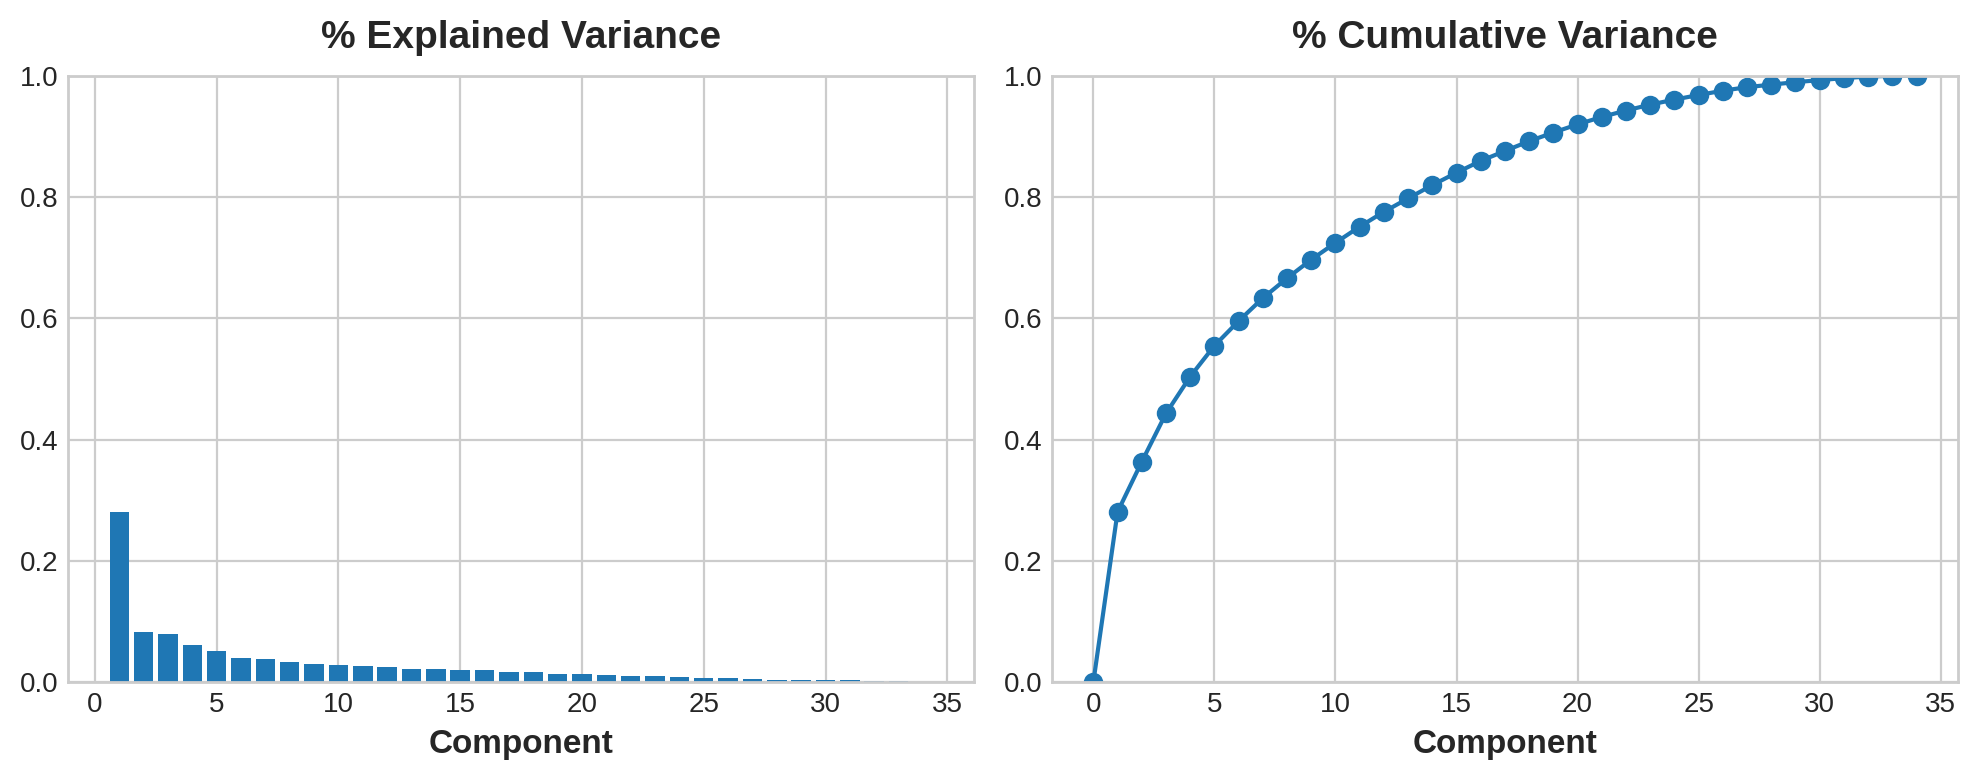

In [68]:
plot_variance(pca)

In [69]:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)
pca_features = mi_scores[mi_scores > 0.1].index

X_pca_inspired = pca_inspired(X)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

X = pd.concat([X, X_pca_inspired], axis=1)

pca = PCA(n_components=1)
pca_pipe = Pipeline(steps=[('scaler', StandardScaler()),('pca',pca)])

pca_coltrans = df_ColumnTransformer(transformers=[('pca_pipe', pca, features_pca_basic),('keep_origin', 'passthrough', features_pca_basic)], remainder='passthrough')
#pca_coltrans = df_ColumnTransformer(transformers=[('pca_pipe', pca, features_pca_basic)], remainder='passthrough')

# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()), 
        #('pca', pca_coltrans),
        ('drop_corr', DropCorr()),                
        (name, model),
    ])        
    
    df_results.loc['pca_inspired', name] = score_dataset(X,y, name, pipe)
    


In [70]:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)
pca_features = mi_scores[mi_scores > 0.1].index

X_pca_inspired = pca_inspired(X)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

#X = pd.concat([X, X_pca_inspired], axis=1)

pca = PCA(n_components=1)
pca_pipe = Pipeline(steps=[('scaler', StandardScaler()),('pca',pca)])

pca_coltrans = df_ColumnTransformer(transformers=[('pca_pipe', pca, features_pca_basic),('keep_origin', 'passthrough', features_pca_basic)], remainder='passthrough')
#pca_coltrans = df_ColumnTransformer(transformers=[('pca_pipe', pca, features_pca_basic)], remainder='passthrough')

# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()), 
        ('pca', pca_coltrans),
        ('drop_corr', DropCorr()),                
        (name, model),
    ])        
    
    df_results.loc['add_pca_main', name] = score_dataset(X,y, name, pipe)
    


In [71]:
df_results

XGBR     skGBR     skRFR     LGBMR
base                     0.143511   0.12689  0.140691  0.129894
no_zero_MI               0.139175  0.127734  0.139115  0.129619
math_transform           0.136766  0.125206  0.138411  0.129726
no_corr                  0.135464  0.125707  0.137078  0.129179
KMeans_labels_no_origin  0.135885  0.126702  0.137101   0.12991
KMeans_labels            0.136587   0.12637  0.137172  0.129909
KMeans_dist              0.140223  0.124534  0.141597  0.130259
pca_inspired              0.14066  0.126692  0.137741  0.130713
add_pca_main             0.138221  0.123885  0.136713  0.127456

Thus, as expected, neither the additing one or more principal components, which explain most of the data variance, 
nor the additional features inspired by PCA analysis improve the results of the tree-based ensemble models significantly.
However, adding the magnitude of the first principal component to the feature set is slightly advantageous for 3 of the four models.
Thus, this procedure can be added to the final data preprocessing pipeline.

-------------------

# 5. Outliers <a class="anchor" id="h5"></a>

As with clustering, the structure of tree-based ensemble models naturally highlights outliers. 
Therefore, various algorithms for their selection and filtering do not play a significant role in the construction of such models, 
which is confirmed by the results obtained. 
In this case, all these methods were considered primarily for demonstration purposes.

## 5.1 Cook's distance <a class="anchor" id="h5.1"></a>

Cook's distance is an estimate of the influence of a data point when performing a least-squares regression analysis. 
The greater the distance, the greater the likelihood that the point is an outlier.

In [73]:
def plot_outliers(df, cols, target_col='SalePrice', outlier_col='no_cluster_scaled'):
    
    for colname in df.select_dtypes(["category"]):
        df[colname] = df[colname].cat.codes    
    
    col_scale = int(np.ceil(len(cols)/2))
    
    fig, axs = plt.subplots(col_scale, 2, figsize=(10, col_scale*4), sharey=True)
    #mapdict = {0: [0,0], 1:[0,1], 2:[1,0], 3:[1,1]}

    for n, c in enumerate(cols):
        axs[n//2, n%2].scatter(df[c], df[target_col], c=df[outlier_col], cmap='plasma', vmin=0, vmax=1.5)
        axs[n//2, n%2].set_xlabel(c)

    axs[0,0].set_ylabel(target_col)
    axs[1,0].set_ylabel(target_col)

    plt.show()

In [74]:
def model_test(X,y, calc_cooks=True):
    x = sm.add_constant(X)
    model = sm.OLS(y, x).fit() 

    if calc_cooks:
        #np.set_printoptions(suppress=True)
        influence = model.get_influence()
        cooks = influence.cooks_distance
               
    return model, np.nan_to_num(cooks[0])

X, y = create_features(df_train)

#model, cook_dist = model_test(X.select_dtypes('number'), y)

cols = ['GrLivArea', 'YearBuilt', 'LotArea', 'OverallQual']
model, cook_dist = model_test(X[cols].replace('None', 0).to_numpy(), np.log(y))
#model, cook_dist = model_test(X.replace('None', 0).to_numpy(), np.log(y))

# Mark as outline data with Cook's distance >= 3*mean(couk_dist)
cdm3 = cook_dist.mean() * 3
X['CooksDist'] = cook_dist
#X['CooksDist'].fillna(0,inplace=True)
X['CooksOut'] = np.where(X['CooksDist'] < cdm3, 0, 1)


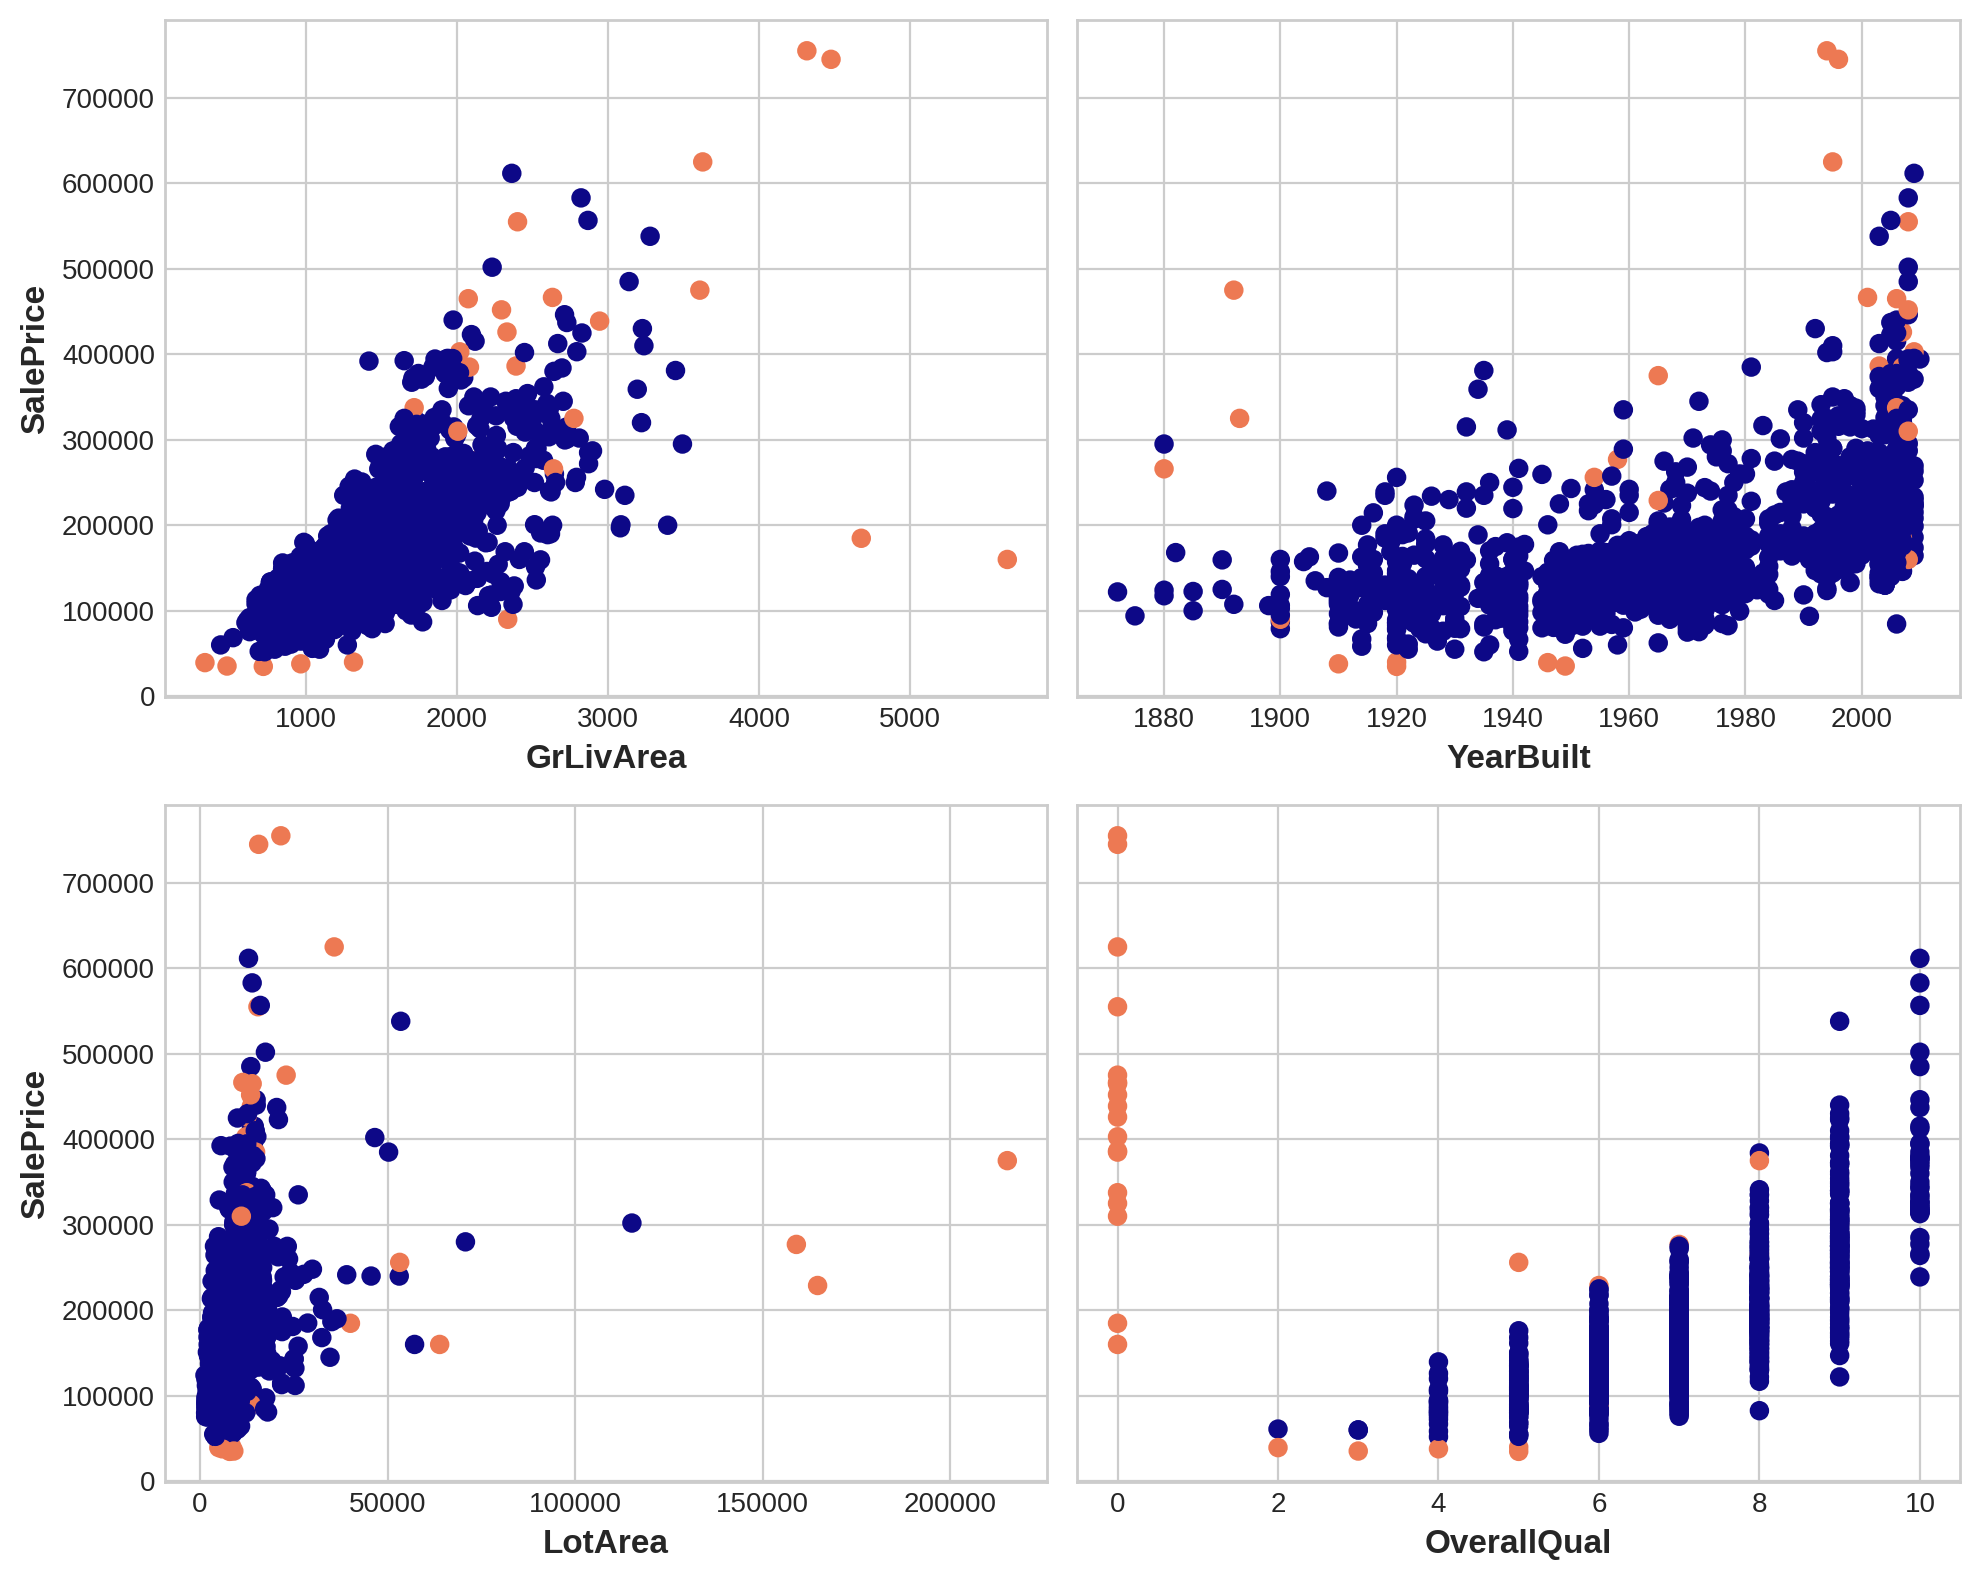

In [75]:
plot_outliers(X.join(y), cols = ['GrLivArea', 'YearBuilt', 'LotArea', 'OverallQual'], outlier_col='CooksOut')

## 5.2 DBSCAN  <a class="anchor" id="h5.2"></a>

DBSCAN is a clustering algorithm that can also be used for outlier detection.

In [77]:
#dbscan_cols = new_features_mi_scores[:9].index.to_list() + ['SaleCondition']
# The columns we will use for DBSCAN: 
dbscan_cols = ['GrLivArea', 'YearBuilt', 'LotArea', 'OverallQual','Neighborhood','SaleCondition']

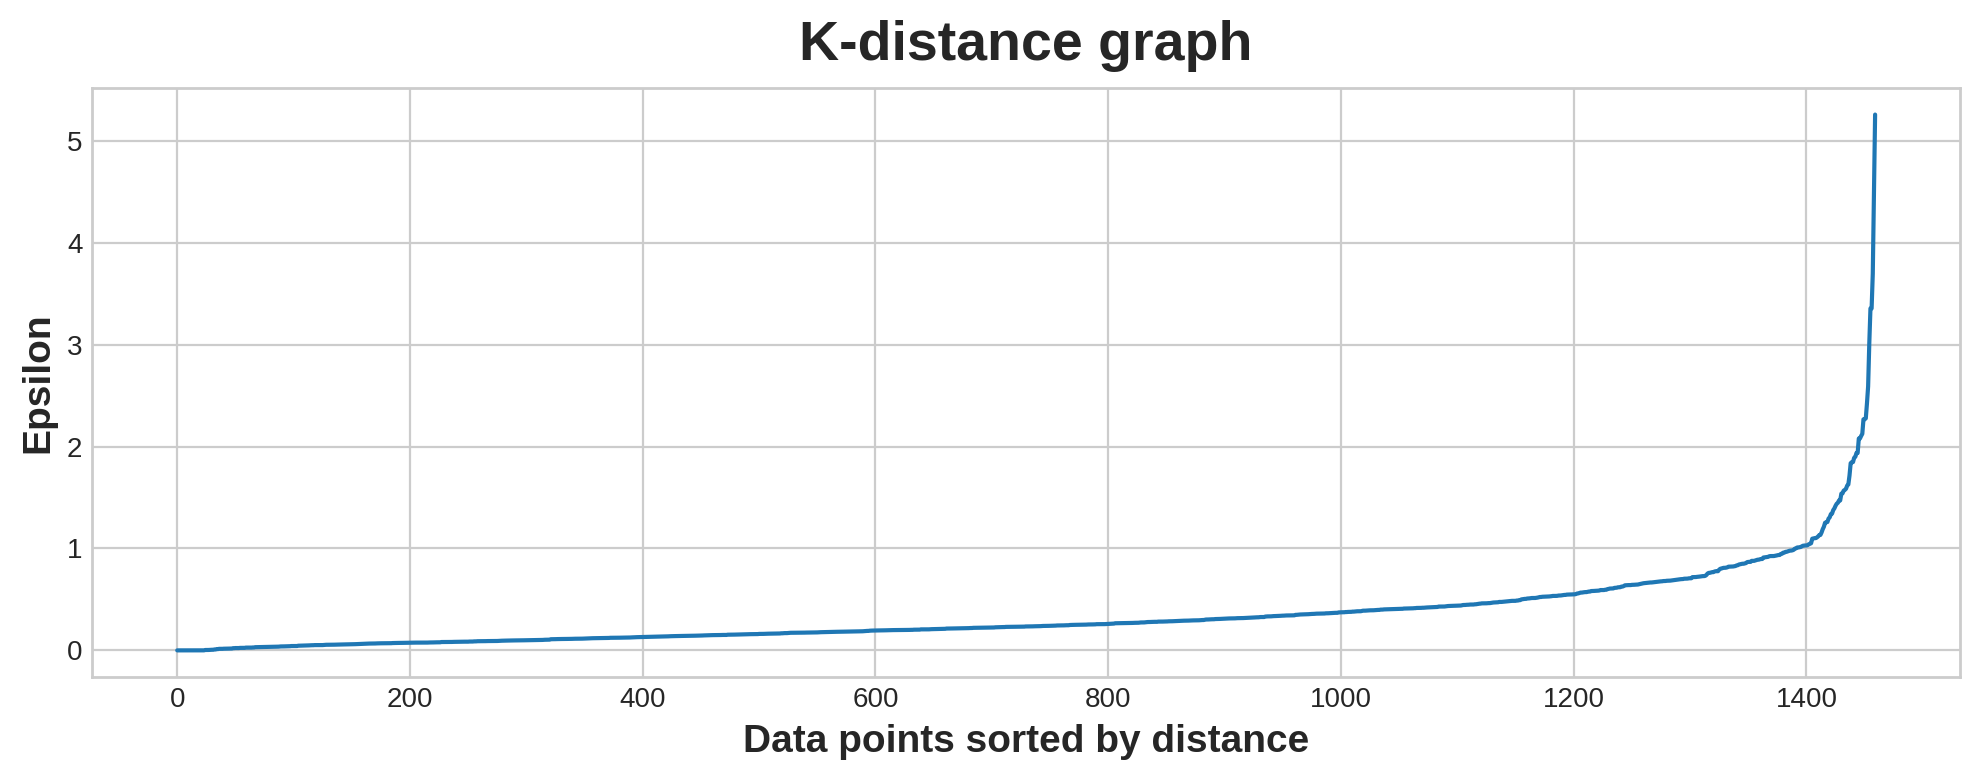

DBSCAN(eps=2.0, min_samples=7)
21
[ 0 -1  1]
CPU times: user 208 ms, sys: 102 µs, total: 209 ms
Wall time: 206 ms


In [78]:
%%time

# TThis procedure is used to determine epsilon, which is the most significant parameter in DBSCAN:
def plot_k_distance_graph(df):
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(df)
    distances, indices = nbrs.kneighbors(df)

    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.figure(figsize=(10,4))
    plt.plot(distances)
    plt.title('K-distance graph',fontsize=20)
    plt.xlabel('Data points sorted by distance',fontsize=14)
    plt.ylabel('Epsilon',fontsize=14)
    plt.show()


def run_dbscan(df, data, target_col='SalePrice', eps=8000, min_samples=284, scaled=''):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    print(dbscan)
    
    for colname in df.select_dtypes(["category"]):
        df[colname] = df[colname].cat.codes # Label endoding       

    dbs = dbscan.fit(df)
    clusters = dbs.labels_
    data[f'cluster{scaled}'] = clusters
    data[f'no_cluster{scaled}'] = np.where(data[f'cluster{scaled}'] == -1, 1, 0)

    print(len(data[data[f'cluster{scaled}'] == -1]))
    print(data[f'cluster{scaled}'].unique())
    return data

def scale_data(df):
    
    for col in df.select_dtypes(['category']):
        df[col] = df[col].cat.codes
        
    #df_scaled = StandardScaler().fit_transform(df)
    df_scaled = (df - df.mean())/df.std()
    
    return df_scaled
         
X, y = create_features(df_train)

df = X.loc[:,dbscan_cols] 

df_scaled = scale_data(df)

# calculate epsilon using the K-distance graph
plot_k_distance_graph(df_scaled)

K_min_samples = df_scaled.shape[1] + 1
# run DBSCAN and return the data with cluster columns
X = run_dbscan(df_scaled, X, eps=2.0, min_samples=K_min_samples, scaled='_scaled')
#print(X.shape)

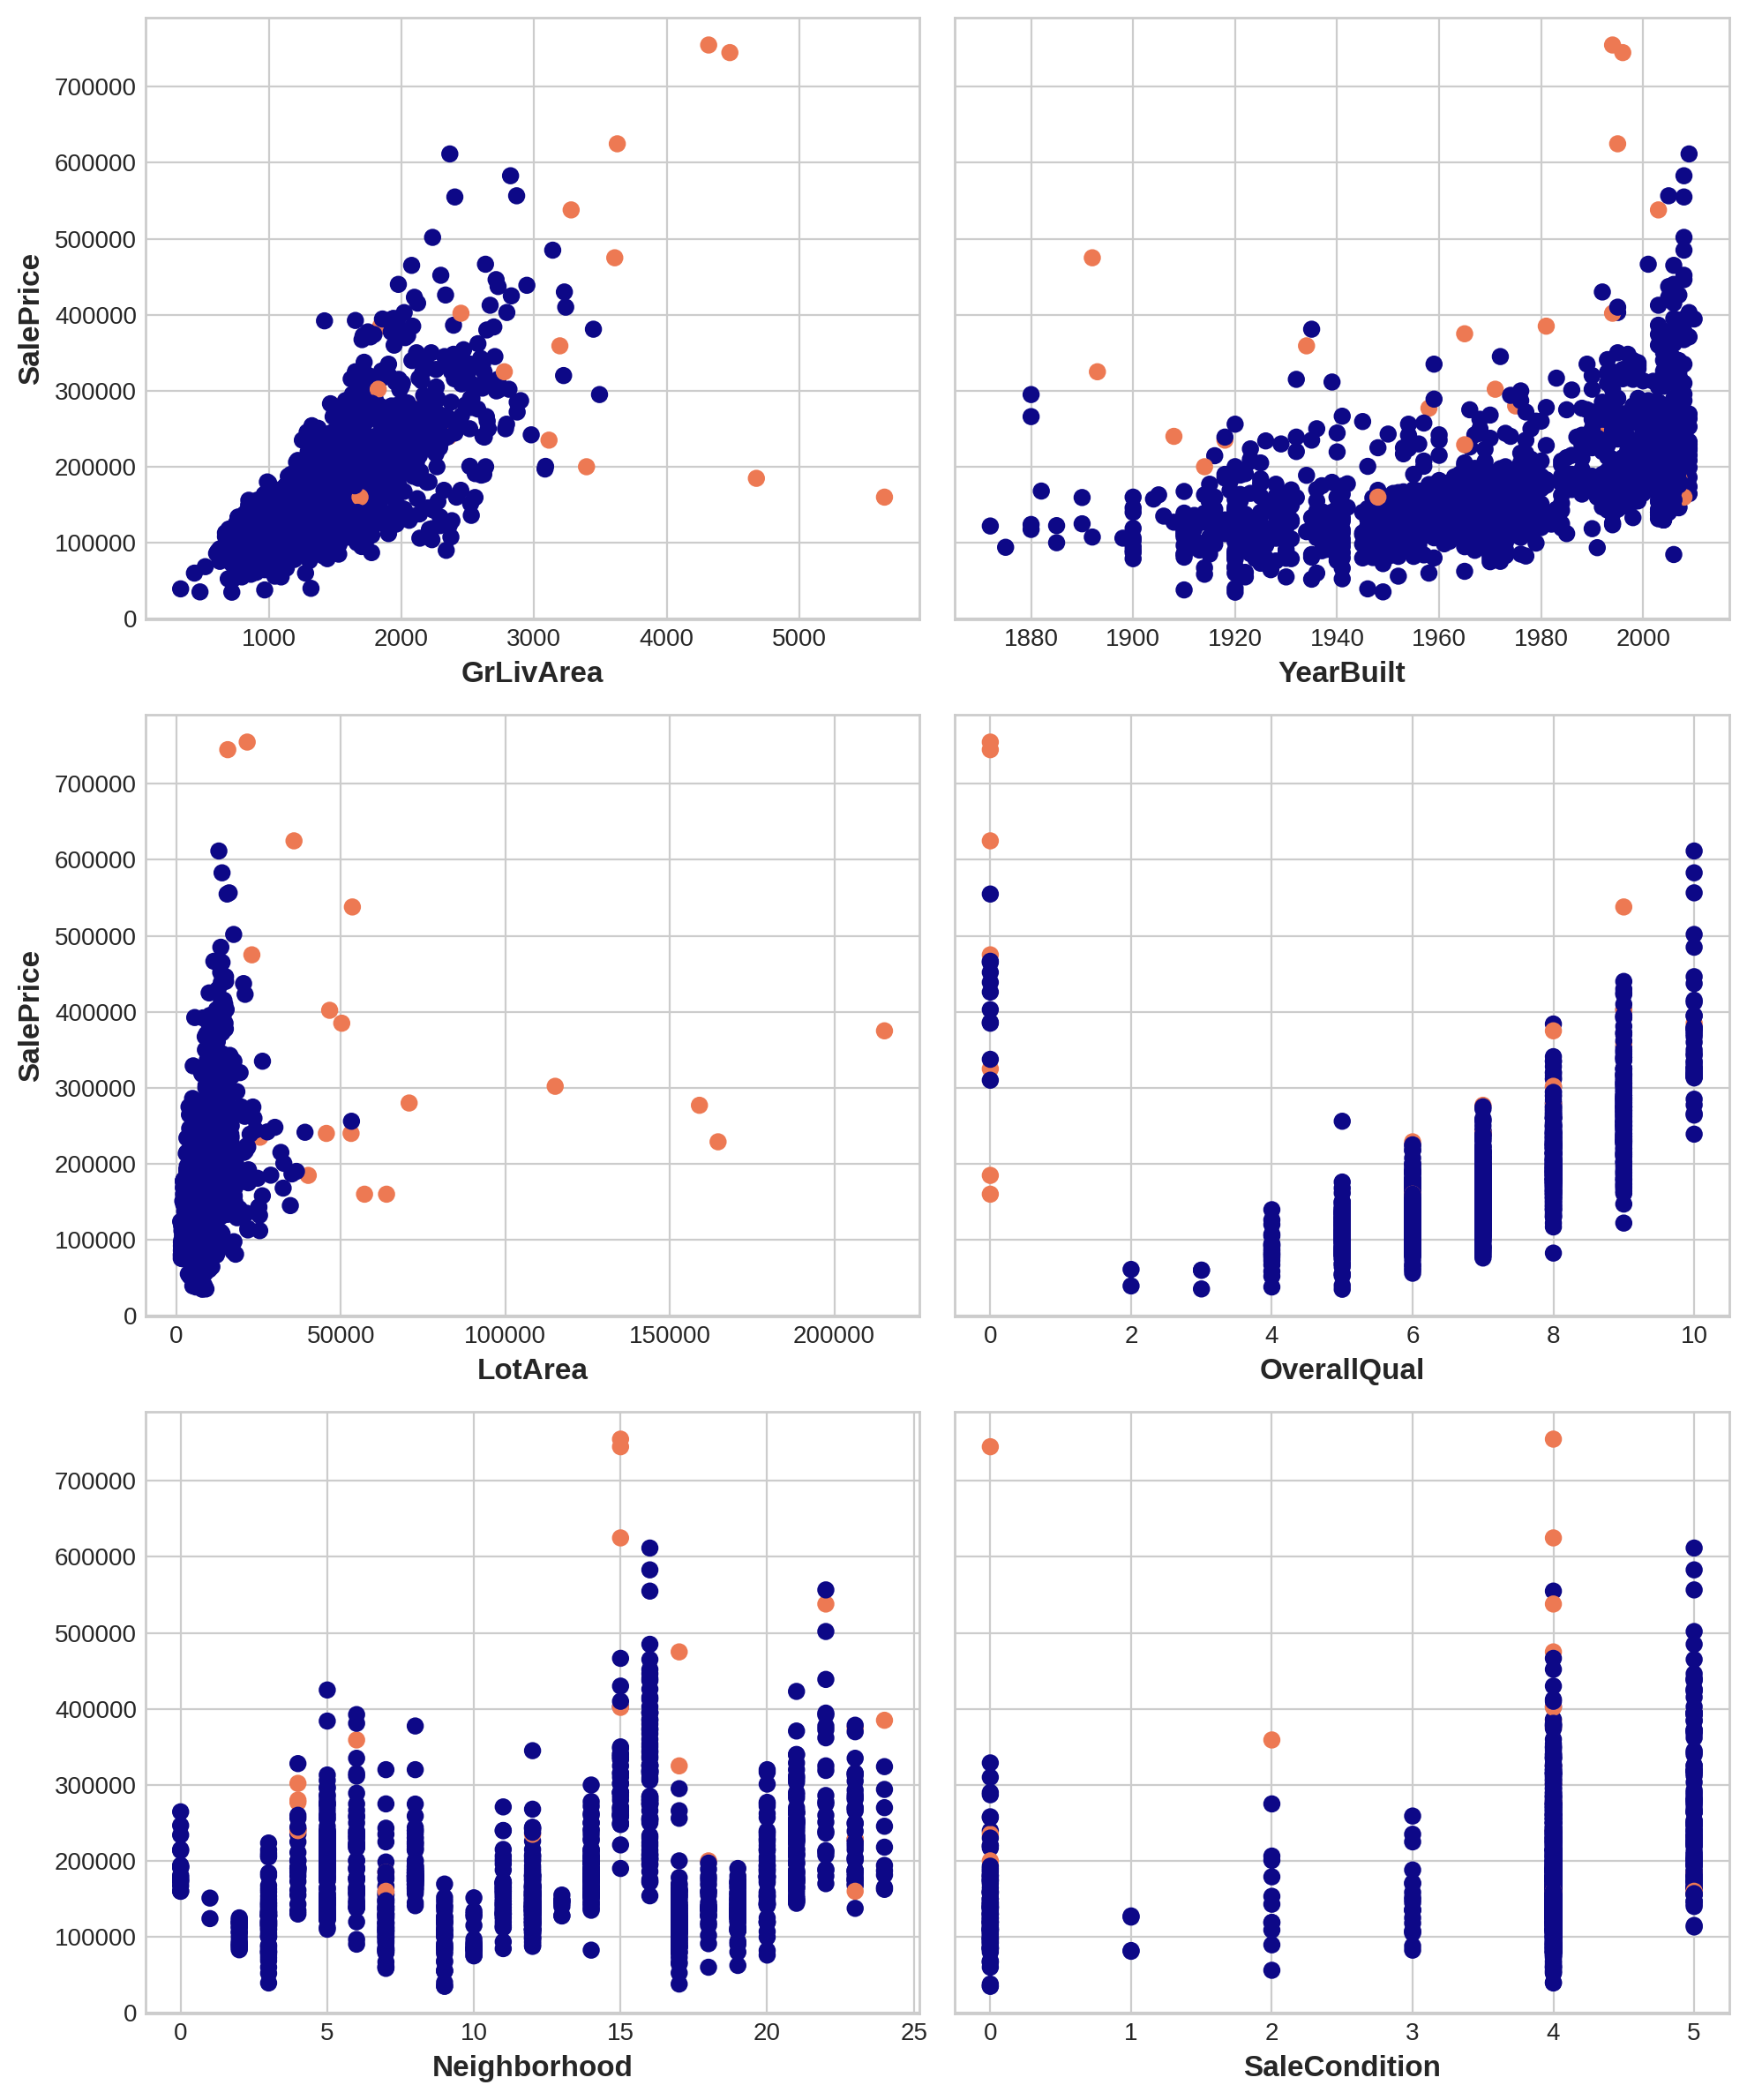

In [79]:
plot_outliers(X[dbscan_cols].join(y).join(X['no_cluster_scaled']),dbscan_cols)

In [80]:
class DBScanOuts(DBSCAN): 
    
    def transform(self, data, y = None):        
        labels = self.fit_predict(data, y)
        labels = np.where(labels == -1, 1, 0)
        return np.nan_to_num(labels.reshape(-1,1))
        
    def fit_transform(self, data, y=None):
        labels = self.fit_predict(data, y)
        labels = np.where(labels == -1, 1, 0)
        return np.nan_to_num(labels.reshape(-1,1))

In [81]:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

# Create the pipe for labeling by DBScan:
k_min_samples = df_scaled.shape[1] + 1

dbs = DBScanOuts(eps=2, min_samples=k_min_samples)
dbs_pipe = Pipeline(steps=[('scaler', StandardScaler()),('dbs',dbs)])

dbs_coltrans = df_ColumnTransformer(transformers=[('dbs_pipe', dbs_pipe, dbscan_cols), ('keep_origin', 'passthrough', dbscan_cols)], remainder='passthrough')

# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()), 
        ('dbs', dbs_coltrans),       
        ('drop_corr', DropCorr()),        
        (name, model),
    ])        
    df_results.loc['dbs', name] = score_dataset(X,y, name, pipe)
    

In [82]:
df_results

XGBR     skGBR     skRFR     LGBMR
base                     0.143511   0.12689  0.140691  0.129894
no_zero_MI               0.139175  0.127734  0.139115  0.129619
math_transform           0.136766  0.125206  0.138411  0.129726
no_corr                  0.135464  0.125707  0.137078  0.129179
KMeans_labels_no_origin  0.135885  0.126702  0.137101   0.12991
KMeans_labels            0.136587   0.12637  0.137172  0.129909
KMeans_dist              0.140223  0.124534  0.141597  0.130259
pca_inspired              0.14066  0.126692  0.137741  0.130713
add_pca_main             0.138221  0.123885  0.136713  0.127456
dbs                      0.137555  0.125782  0.137517  0.129193

## 5.3 Summury <a class="anchor" id="h5.3"></a>

So, as expected, we did not gain any benefit from detecting and labeling outliers to improve the prediction quality of tree-based models.

---------------

# 6. Target encoding <a class="anchor" id="h6"></a>

In [83]:
from category_encoders import MEstimateEncoder, CatBoostEncoder
from functools import reduce

In [84]:
''' The encoder based on the papaer: 
    Daniele Micci-Barreca, A Preprocessing Scheme for High-Cardinality Categorical Attributes in Classification and Prediction Problems, 
    ACM SIGKDD Explorations Newsletter, 2001'''

# Empirical Bayes encoder:
class EBencoder:
   
    def __init__(self, cols=None, target=None):
        self.cols_ = cols
        self.target_ = target
    
     
    @staticmethod
    def get_code(n_cell, mean_cell, var_cell, mean_prior, var_prior):    
    
        lambda_factor = n_cell*var_prior/(var_cell + n_cell*var_prior)   
        #lambda_factor.fillna(0, inplace=True)
        if np.isnan(lambda_factor):
            lambda_factor = 0
        code = lambda_factor*mean_cell + (1-lambda_factor)*mean_prior
    
        return code
    
    def encode(self, df, target, col): 
        
        self.y_mean_prior = df[~df[target].isnull()][target].mean()
        self.y_var_prior = df[~df[target].isnull()][target].var()
        
        val_dict = df.groupby(col)[target].apply(lambda x: self.get_code(x.size,x.mean(),x.var(),self.y_mean_prior,self.y_var_prior)).to_dict() 
                       
        return val_dict

    def fit(self, X, y=None):         
        if not self.cols_:
            self.cols_ = X.columns
        if y is None: 
            if not self.target_:
                raise IOError("Target column name must be specified of target values explicitly provided!")
            df_encode = X
        else:
            df_encode = X[self.cols_].join(y)          
            if not self.target_:
                self.target_ = y.name
                
        self.cols_coded = {col: self.encode(df_encode, self.target_, col) for col in self.cols_}
        
        return self
        
    
    def transform(self, X):
        
        #df_transformed = X[self.cols_].copy()
        df_transformed = pd.DataFrame()
        
        for col in self.cols_coded:            
            df_transformed[col] = X[col].map(self.cols_coded[col])
            
        df_transformed.fillna(self.y_mean_prior, inplace=True)
        
        XX = X.copy()
        XX.update(df_transformed)
            
        return XX
    
        
    def fit_transform(self, X, y):        
        return self.fit(X,y).transform(X)

In [85]:
'''
This class is needed to generalize the procedure for encoding features, preventing data leakage and subsequent overfitting.
'''
class CrossFoldEncoder:
    def __init__(self, encoder, cols, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)
        self.cols_ = cols

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y):
        self.fitted_encoders_ = []        
        X_encoded = []
        for i, (idx_encode, idx_train) in enumerate(self.cv_.split(X)):
                        
            fitted_encoder = self.encoder_(cols=self.cols_, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :]))
            
            self.fitted_encoders_.append(fitted_encoder)                
      
        X_encoded = pd.concat(X_encoded)
        #X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        
        return X_encoded

    # To transform the test data, average the encodings learned from each fold:       
    def transform(self, X, y=None):       
        X_encoded_list = []
        
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        
        X_encoded = reduce(lambda x, y: x.add(y, fill_value=0), X_encoded_list) / len(X_encoded_list)
        #X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        
        XX = X.copy()
        XX.update(X_encoded)
        
        return XX

In [86]:
s = X.select_dtypes("category").nunique() > 10
target_cols = s[s].index.to_list()

In [88]:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

encoder = CrossFoldEncoder(CatBoostEncoder,cols=target_cols, a=3)

# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()),         
        ('drop_corr', DropCorr()),   
        ('encoder', encoder),  
        (name, model),
    ])        
    df_results.loc['CB_encode', name] = score_dataset(X,y, name, pipe)
    #print(f'{name} = {score_dataset(X,y,name,pipe)}')
    

In [89]:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

encoder = CrossFoldEncoder(MEstimateEncoder,cols=target_cols, m=2)

# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()),         
        ('drop_corr', DropCorr()),   
        ('encoder', encoder),  
        (name, model),
    ])        
    df_results.loc['ME_encode', name] = score_dataset(X,y, name, pipe)
    #print(f'{name} = {score_dataset(X,y,name,pipe)}')
    

In [90]:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

encoder = CrossFoldEncoder(EBencoder,cols=target_cols)

# Evaluate the model
for model, name in zip(models, model_names): 
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()),         
        ('drop_corr', DropCorr()),   
        ('encoder', encoder),  
        (name, model),
    ])        
    df_results.loc['EB_encode', name] = score_dataset(X,y, name, pipe)
    #print(f'{name} = {score_dataset(X,y,name,pipe)}')
    

In [91]:
df_results

XGBR     skGBR     skRFR     LGBMR
base                     0.143511   0.12689  0.140691  0.129894
no_zero_MI               0.139175  0.127734  0.139115  0.129619
math_transform           0.136766  0.125206  0.138411  0.129726
no_corr                  0.135464  0.125707  0.137078  0.129179
KMeans_labels_no_origin  0.135885  0.126702  0.137101   0.12991
KMeans_labels            0.136587   0.12637  0.137172  0.129909
KMeans_dist              0.140223  0.124534  0.141597  0.130259
pca_inspired              0.14066  0.126692  0.137741  0.130713
add_pca_main             0.138221  0.123885  0.136713  0.127456
dbs                      0.137555  0.125782  0.137517  0.129193
CB_encode                0.141899  0.125193  0.136732   0.13063
ME_encode                 0.14171  0.125496  0.137863  0.131572
EB_encode                0.141571  0.126364  0.137363  0.131188

As expected, there is no advantage from from using target encoding of any type.

----------------------------

# 7. Hyperparameter optimization  <a class="anchor" id="h7"></a>

In this section, we excluded RandomForestRegressor from consideration as it showed the worst results on default settings.
Obviously, the parameters of all other stages of data preparation (MI filtering, dropping correlated data) can be optimized in a similar way.

There are many hyperparameter optimization algorithms, and choosing the right one depends on several conditions such as the type of ML problem, computational budget, etc.
However, in this study, we did not delve into the theory and practice of hyperparameter fitting or black box optimization, but used the default Optuna parameters for searching.

## 7.1 XGBRegressor parameter optimization <a class="anchor" id="h7.1"></a>

In [118]:
X, y = create_features(df_train)

# Evaluate the MI score for the dataset updated:
mi_scores = make_mi_scores(X, y)

# Drop the features with zero MI:
X = drop_uninformative(X, mi_scores, mi_min=mi_min_val)

In [153]:
def opt_objective(trial):
    
    n_pca_comp = trial.suggest_int("pca_n_comp", 0, 4)
    
    pca = PCA(n_components=n_pca_comp)
    pca_pipe = Pipeline(steps=[('scaler', StandardScaler()),('pca',pca)])

    pca_coltrans = df_ColumnTransformer(transformers=[('pca_pipe', pca, features_pca_basic),('keep_origin', 'passthrough', features_pca_basic)], remainder='passthrough')
    
    xgb_params = dict(        
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
        
    xgbr_model = XGBRegressor(**xgb_params)
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()),  
        ('pca', pca_coltrans),
        ('drop_corr', DropCorr()),           
        ('XGBR', xgbr_model),
    ]) 
    
    score = score_dataset(X,y, 'XGBR', pipe)                                  
  
    return score

In [159]:
optuna.logging.set_verbosity(optuna.logging.WARN)

study = optuna.create_study(direction="minimize")
study.optimize(func=opt_objective, 
               n_trials=200,
               show_progress_bar=True)

/home/jose/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

In [162]:
study.best_value

0.11540361687810069

In [163]:
study.best_params

{'pca_n_comp': 1,
 'max_depth': 4,
 'learning_rate': 0.004683627942048655,
 'n_estimators': 7637,
 'min_child_weight': 1,
 'colsample_bytree': 0.28453059024071603,
 'subsample': 0.4577341330473378,
 'reg_alpha': 0.00022304940124577796,
 'reg_lambda': 0.0003612142479524421}

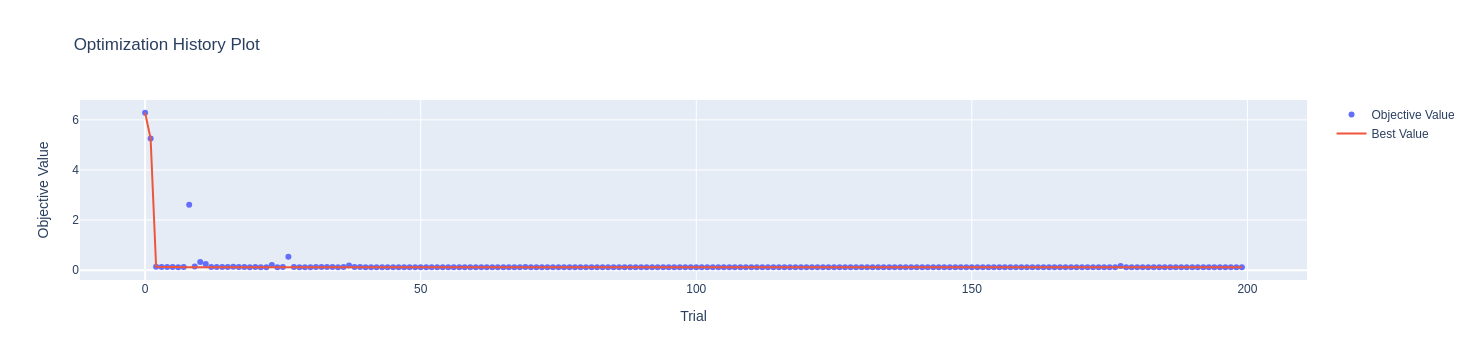

In [165]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study=study)

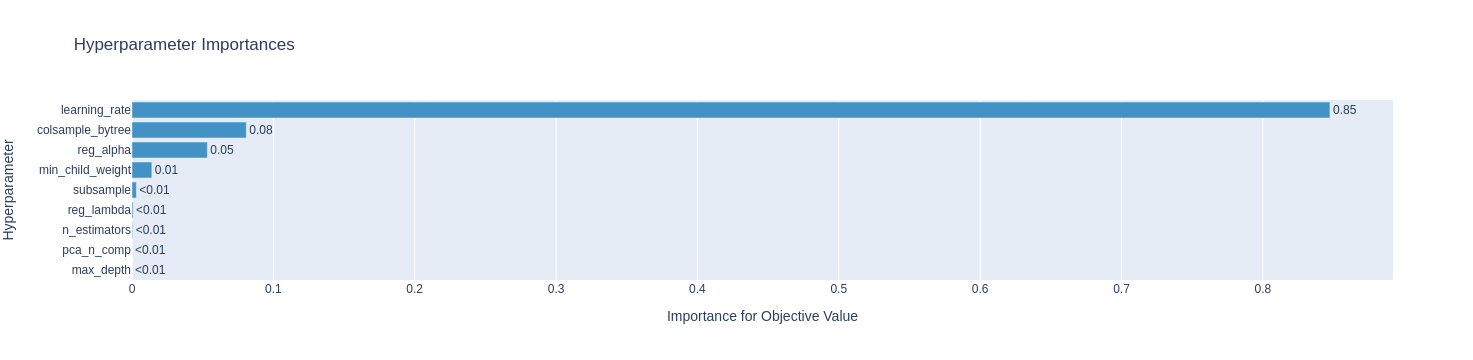

In [167]:
from optuna.visualization import plot_param_importances

plot_param_importances(study=study)

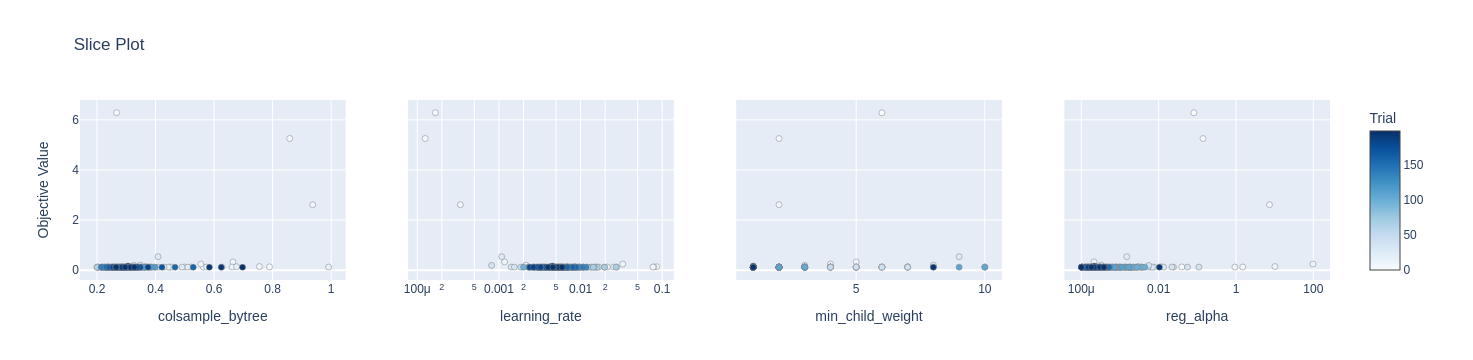

In [172]:
from optuna.visualization import plot_slice

plot_slice(study = study,
           params = ['learning_rate', 'colsample_bytree', 'reg_alpha', 'min_child_weight'])

## 7.2 LGBMRegressor parameter optimization <a class="anchor" id="h7.2"></a>

In [175]:
def opt_objective(trial):
    
    n_pca_comp = trial.suggest_int("pca_n_comp", 0, 4)
    
    pca = PCA(n_components=n_pca_comp)
    pca_pipe = Pipeline(steps=[('scaler', StandardScaler()),('pca',pca)])

    pca_coltrans = df_ColumnTransformer(transformers=[('pca_pipe', pca, features_pca_basic),('keep_origin', 'passthrough', features_pca_basic)], remainder='passthrough')
    
    lgb_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 20),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-0, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 15000),
        min_child_weight=trial.suggest_float("min_child_weight", 0, 10),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),
        reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
        reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
    )
    
    lgbmr_model = lgb.LGBMRegressor(**lgb_params)
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()),  
        ('pca', pca_coltrans),
        ('drop_corr', DropCorr()),           
        ('LGBMR', lgbmr_model),
    ]) 
    
    score = score_dataset(X,y, 'LGBMR', pipe)                                  
  
    return score


In [176]:
study = optuna.create_study(direction="minimize")
study.optimize(func=opt_objective, 
               n_trials=100,
               show_progress_bar=True)

/home/jose/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

In [177]:
study.best_value

0.12187981203697111

In [178]:
study.best_params

{'pca_n_comp': 1,
 'max_depth': 15,
 'learning_rate': 0.010354672345224945,
 'n_estimators': 12912,
 'min_child_weight': 7.989061181126354,
 'colsample_bytree': 0.2347588377237159,
 'subsample': 0.7447098898816122,
 'reg_alpha': 0.03695465106845624,
 'reg_lambda': 0.02367136919740087}

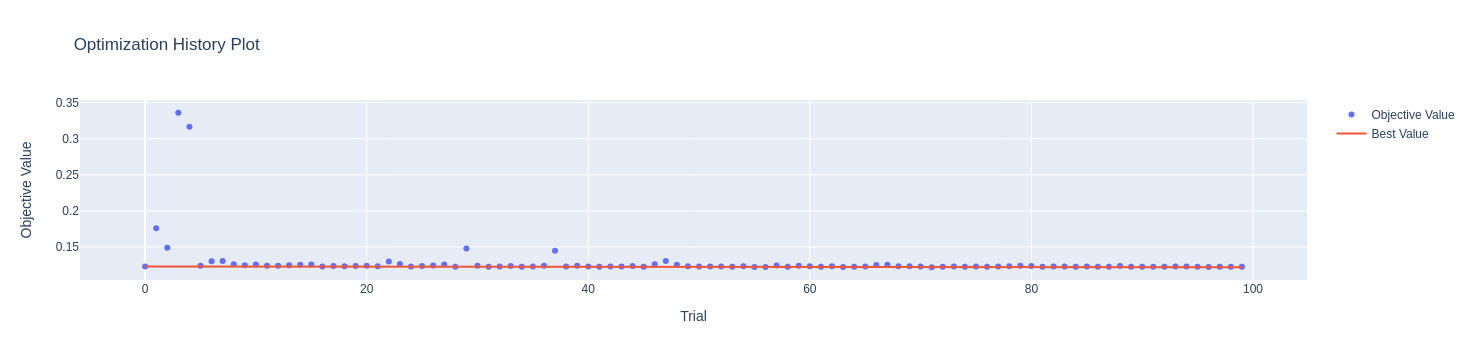

In [179]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study=study)

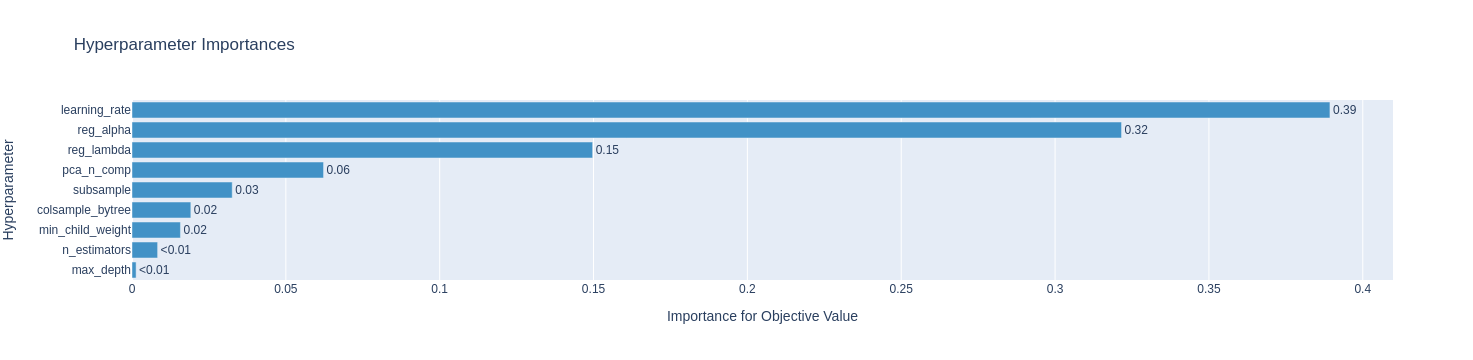

In [180]:
from optuna.visualization import plot_param_importances

plot_param_importances(study=study)

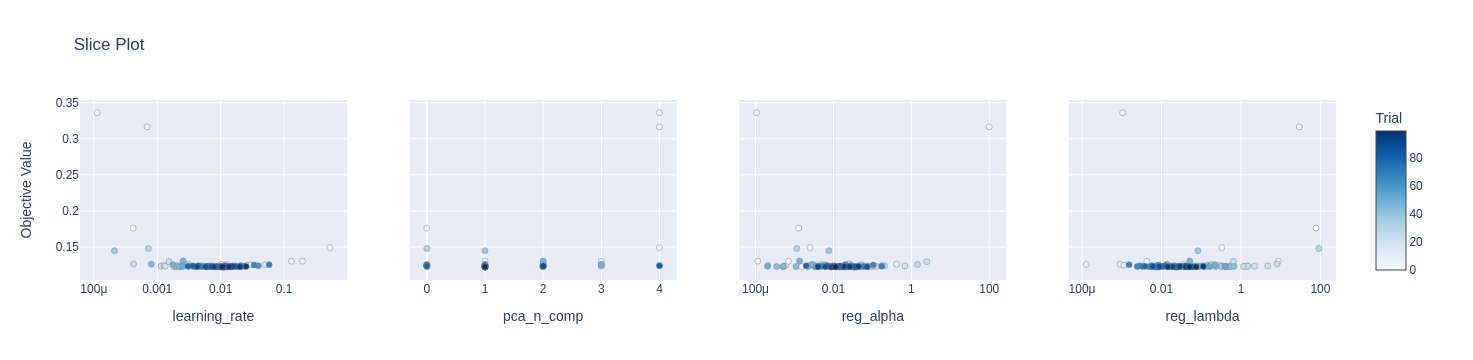

In [181]:
from optuna.visualization import plot_slice

plot_slice(study = study,
           params = ['learning_rate', 'reg_alpha', 'reg_lambda', 'pca_n_comp'])

## 7.3 GradientBoostingRegressor parameter optimization <a class="anchor" id="h7.3"></a>

In [182]:
def opt_objective(trial):
    
    n_pca_comp = trial.suggest_int("pca_n_comp", 0, 4)
    
    pca = PCA(n_components=n_pca_comp)
    pca_pipe = Pipeline(steps=[('scaler', StandardScaler()),('pca',pca)])

    pca_coltrans = df_ColumnTransformer(transformers=[('pca_pipe', pca, features_pca_basic),('keep_origin', 'passthrough', features_pca_basic)], remainder='passthrough')
    
    gbr_params = dict(
        max_depth=trial.suggest_int("max_depth", 2, 10),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        n_estimators=trial.suggest_int("n_estimators", 1000, 8000),
        min_weight_fraction_leaf=trial.suggest_float("min_weight_fraction_leaf", 0, 0.5),
        max_features=trial.suggest_float("colsample_bytree", 0.2, 1.0),
        subsample=trial.suggest_float("subsample", 0.2, 1.0),        
    )
    
    gbr_model = skGBR(**gbr_params)
    
    pipe = Pipeline(steps=[
        ('gp', GroupTransform()),  
        ('pca', pca_coltrans),
        ('drop_corr', DropCorr()),           
        ('skGBR', gbr_model),
    ]) 
    
    score = score_dataset(X,y, 'skGBR', pipe)                                  
  
    return score

In [183]:
study = optuna.create_study(direction="minimize")
study.optimize(func=opt_objective, 
               n_trials=100,
               show_progress_bar=True)

/home/jose/anaconda3/lib/python3.7/site-packages/optuna/progress_bar.py:56: ExperimentalWarning:

Progress bar is experimental (supported from v1.2.0). The interface can change in the future.



  0%|          | 0/100 [00:00<?, ?it/s]

In [184]:
study.best_value

0.11675916044467796

In [185]:
study.best_params

{'pca_n_comp': 1,
 'max_depth': 4,
 'learning_rate': 0.0061259656535711466,
 'n_estimators': 3864,
 'min_weight_fraction_leaf': 0.004742272350118487,
 'colsample_bytree': 0.2501833298626871,
 'subsample': 0.4715051969803711}

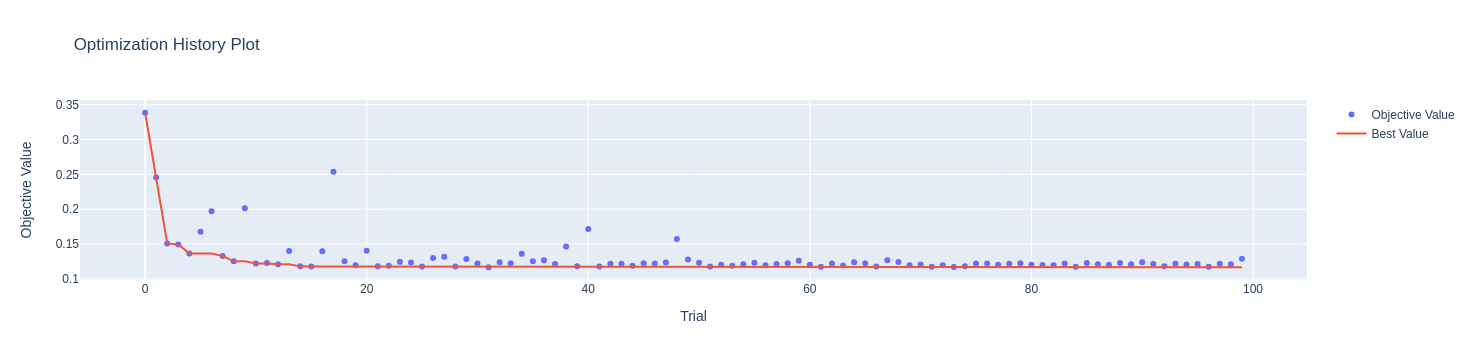

In [186]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study=study)

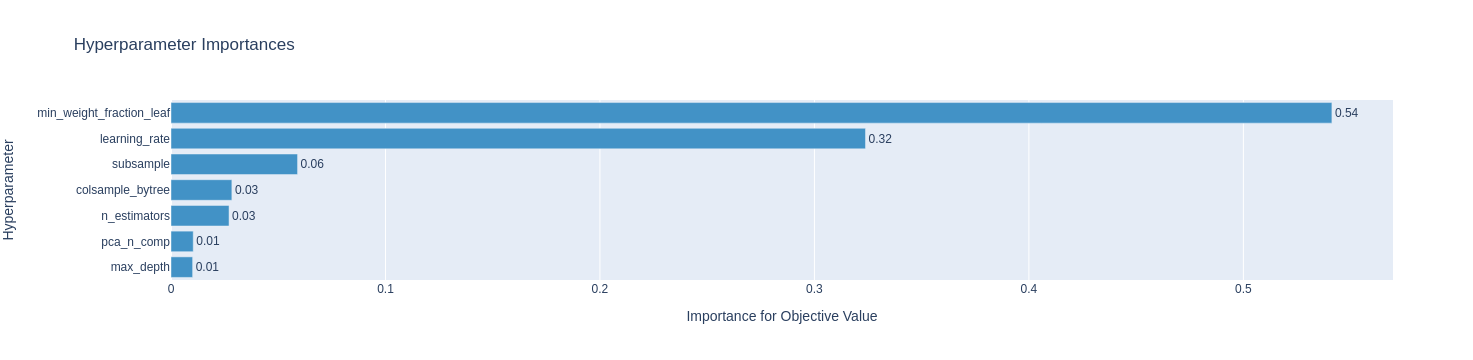

In [187]:
from optuna.visualization import plot_param_importances

plot_param_importances(study=study)

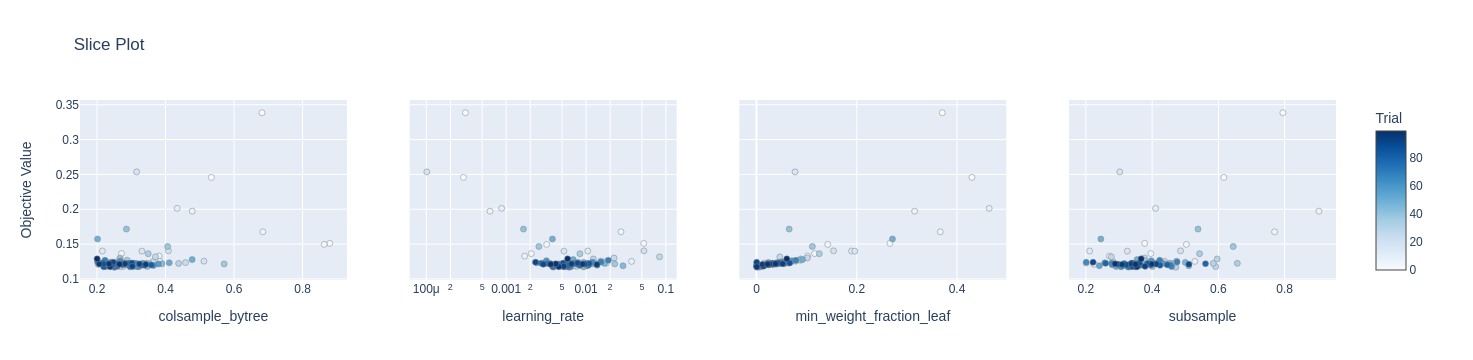

In [189]:
from optuna.visualization import plot_slice

plot_slice(study = study,
           params = ['learning_rate', 'min_weight_fraction_leaf', 'subsample', 'colsample_bytree'])